In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import test.utils as test

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
# params_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)
# params_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)

# UMI_c57 = pd.read_csv('data_arme/nature_paper/SS3_c57_UMIs_concat.csv', index_col=0)
# UMI_cast = pd.read_csv('data_arme/nature_paper/SS3_cast_UMIs_concat.csv', index_col=0)


In [4]:
# sum the UMI counts into a single dataframe
UMI = UMI_c57 + UMI_cast

In [5]:
# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

In [6]:
adata = ad.AnnData(UMI_T)
adata.layers['spliced'] = UMI_c57_T
adata.layers['unspliced'] = UMI_cast_T
adata

AnnData object with n_obs × n_vars = 682 × 23270
    layers: 'spliced', 'unspliced'

In [7]:
adata

AnnData object with n_obs × n_vars = 682 × 23270
    layers: 'spliced', 'unspliced'

In [8]:
test.remove_na(adata)

In [9]:
adata

AnnData object with n_obs × n_vars = 682 × 5066
    layers: 'spliced', 'unspliced'

In [10]:
test.find_ratios_sum(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 682 × 4070
    var: 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2'
    layers: 'spliced', 'unspliced'

In [12]:
adata.var

,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2
ENSMUSG00000000001,8956.0,10024.0,0.471865,0.528135
ENSMUSG00000000049,46.0,48.0,0.489362,0.510638
ENSMUSG00000000088,7514.0,7028.0,0.516710,0.483290
ENSMUSG00000000120,0.0,4.0,0.000000,1.000000
ENSMUSG00000000184,36198.0,33010.0,0.523032,0.476968
...,...,...,...,...
ENSMUSG00000113877,1.0,0.0,1.000000,0.000000
ENSMUSG00000114922,2.0,0.0,1.000000,0.000000
ENSMUSG00000115141,2.0,0.0,1.000000,0.000000
ENSMUSG00000115454,1.0,0.0,1.000000,0.000000


In [13]:
test.find_ratios_std(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 682 × 3134
    var: 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2', 'ratio_sum_allele_1', 'ratio_sum_allele_2', 'ratio_mean_allele_1', 'ratio_mean_allele_2', 'ratio_std_allele_1', 'ratio_std_allele_2'
    layers: 'spliced', 'unspliced', 'ratio_allele_1', 'ratio_allele_2'

In [15]:
adata.var

,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2
ENSMUSG00000000001,8956.0,10024.0,0.471865,0.528135,321.291178,360.708822,0.471101,0.528899,0.157535,0.157535
ENSMUSG00000000049,46.0,48.0,0.489362,0.510638,29.500000,34.500000,0.460938,0.539062,0.498447,0.498447
ENSMUSG00000000088,7514.0,7028.0,0.516710,0.483290,350.605317,331.394683,0.514084,0.485916,0.151797,0.151797
ENSMUSG00000000120,0.0,4.0,0.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000
ENSMUSG00000000184,36198.0,33010.0,0.523032,0.476968,357.947744,324.052256,0.524850,0.475150,0.144606,0.144606
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000100620,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000103811,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000112500,6.0,0.0,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ENSMUSG00000114922,2.0,0.0,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [16]:
selected_genes_1 = ['ENSMUSG00000001131', 'ENSMUSG00000008682', 'ENSMUSG00000031320', 
     'ENSMUSG00000031375', 'ENSMUSG00000044533']
selected_genes_2 = ['ENSMUSG00000081094', 'ENSMUSG00000098178']
selected_genes = ['ENSMUSG00000001131', 'ENSMUSG00000008682', 'ENSMUSG00000031320', 
     'ENSMUSG00000031375', 'ENSMUSG00000044533', 'ENSMUSG00000081094', 'ENSMUSG00000098178']

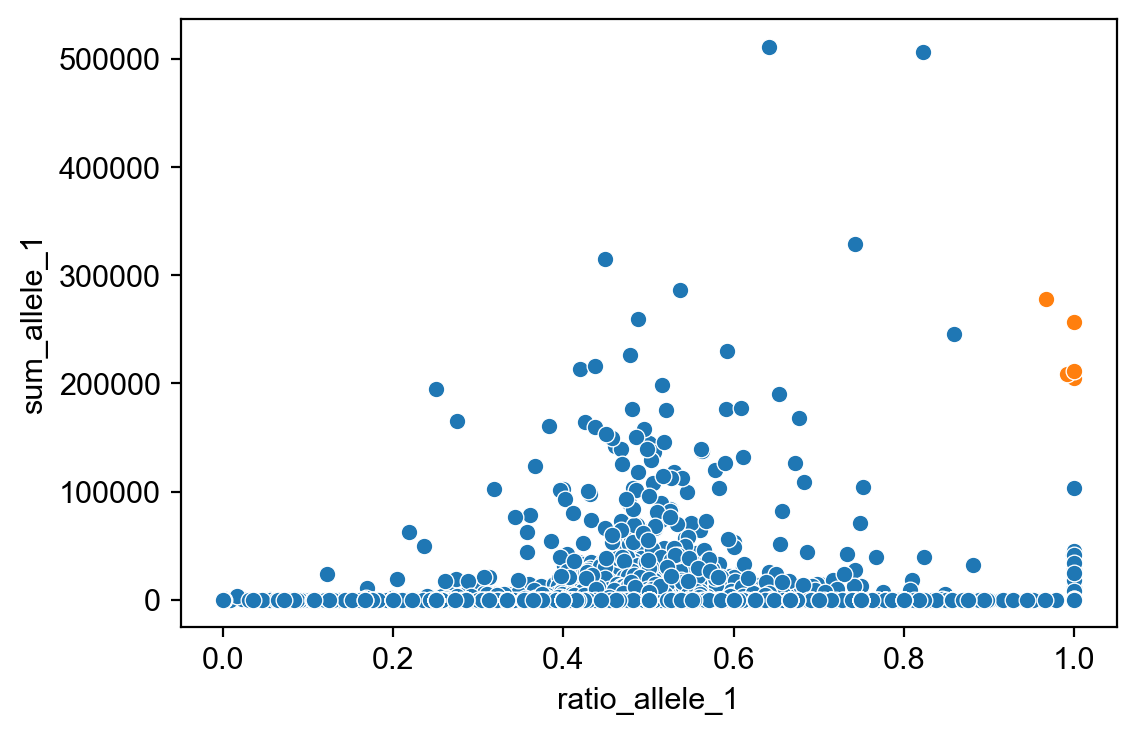

In [17]:
test.sns_scatter(x="ratio_allele_1", y="sum_allele_1", data=adata.var, selected_genes=selected_genes_1)

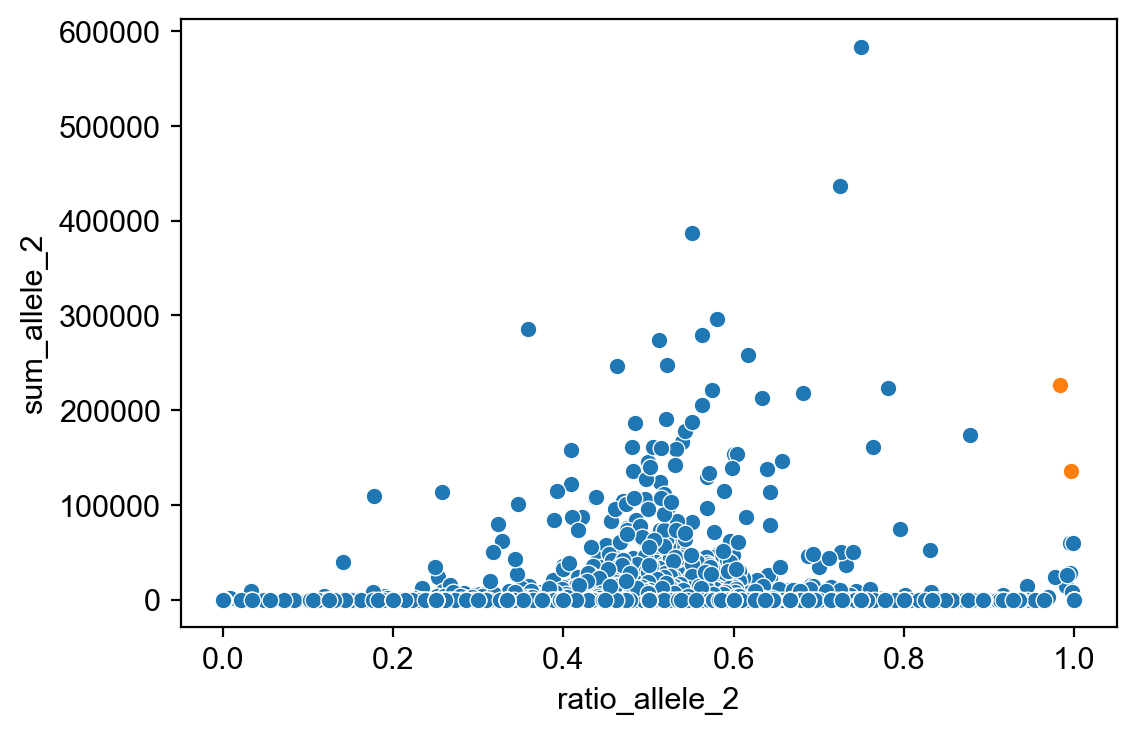

In [18]:
test.sns_scatter(x="ratio_allele_2", y="sum_allele_2", data=adata.var, selected_genes=selected_genes_2)

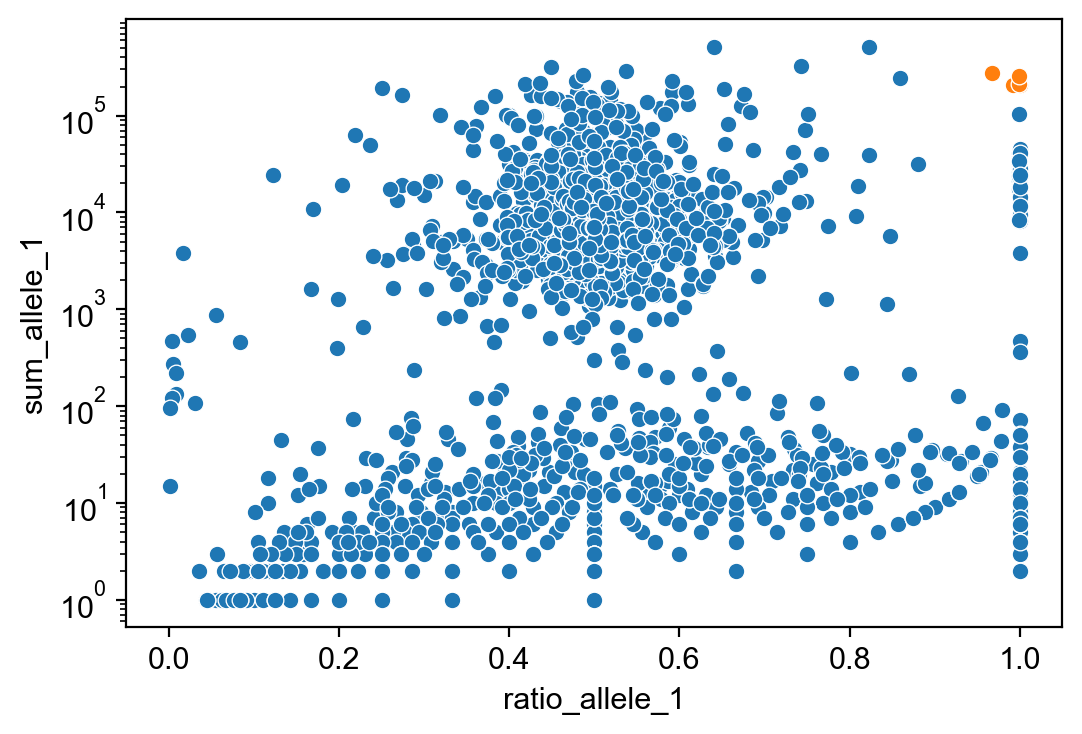

In [19]:
test.sns_scatter(x="ratio_allele_1", y="sum_allele_1", data=adata.var, selected_genes=selected_genes_1, is_log_scale=True)

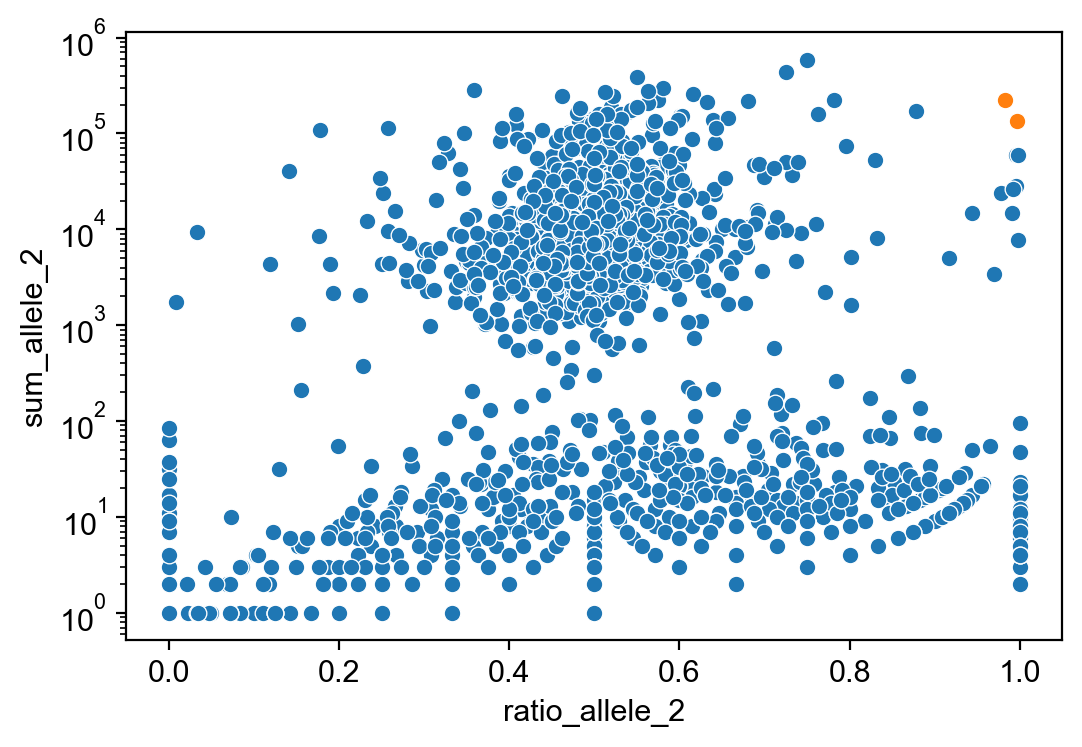

In [20]:
test.sns_scatter(x="ratio_allele_2", y="sum_allele_2", data=adata.var, selected_genes=selected_genes_2, is_log_scale=True)

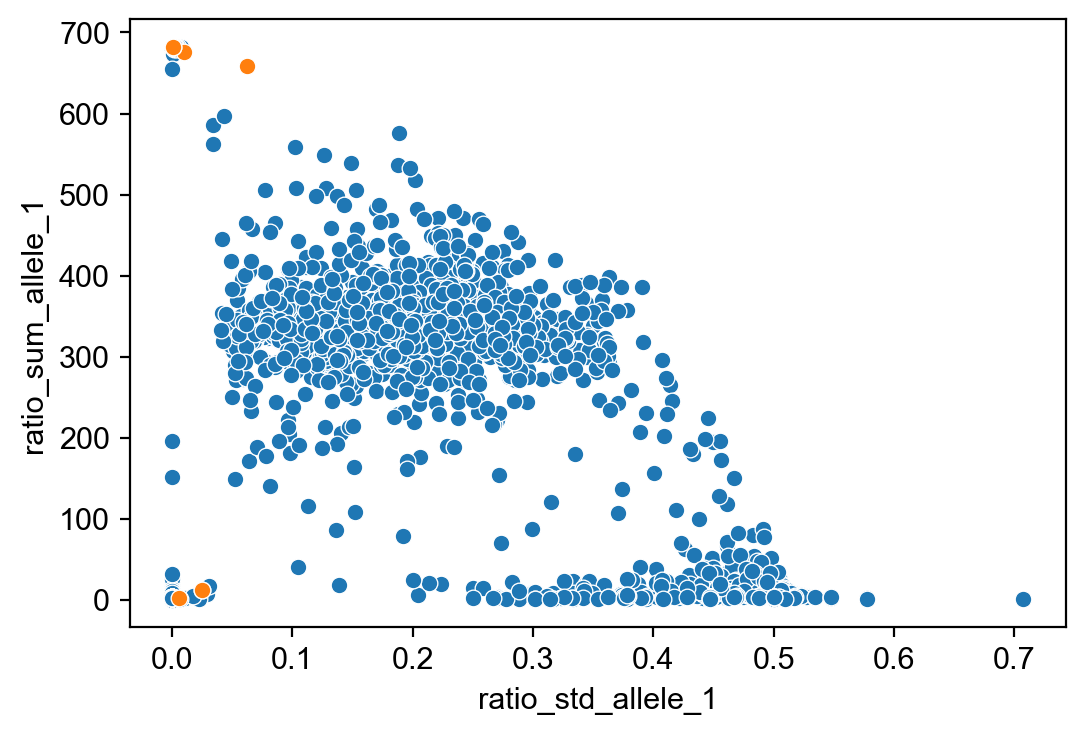

In [21]:
test.sns_scatter(x="ratio_std_allele_1", y="ratio_sum_allele_1", data=adata.var, selected_genes=selected_genes)

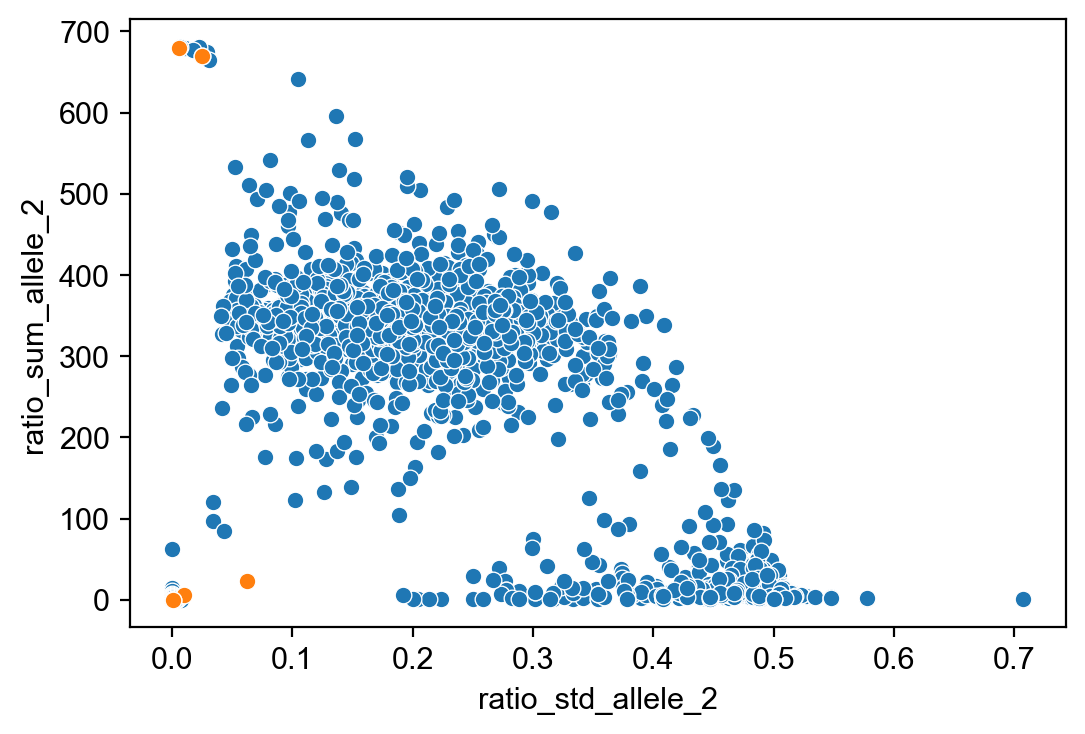

In [22]:
test.sns_scatter(x="ratio_std_allele_2", y="ratio_sum_allele_2", data=adata.var, selected_genes=selected_genes)

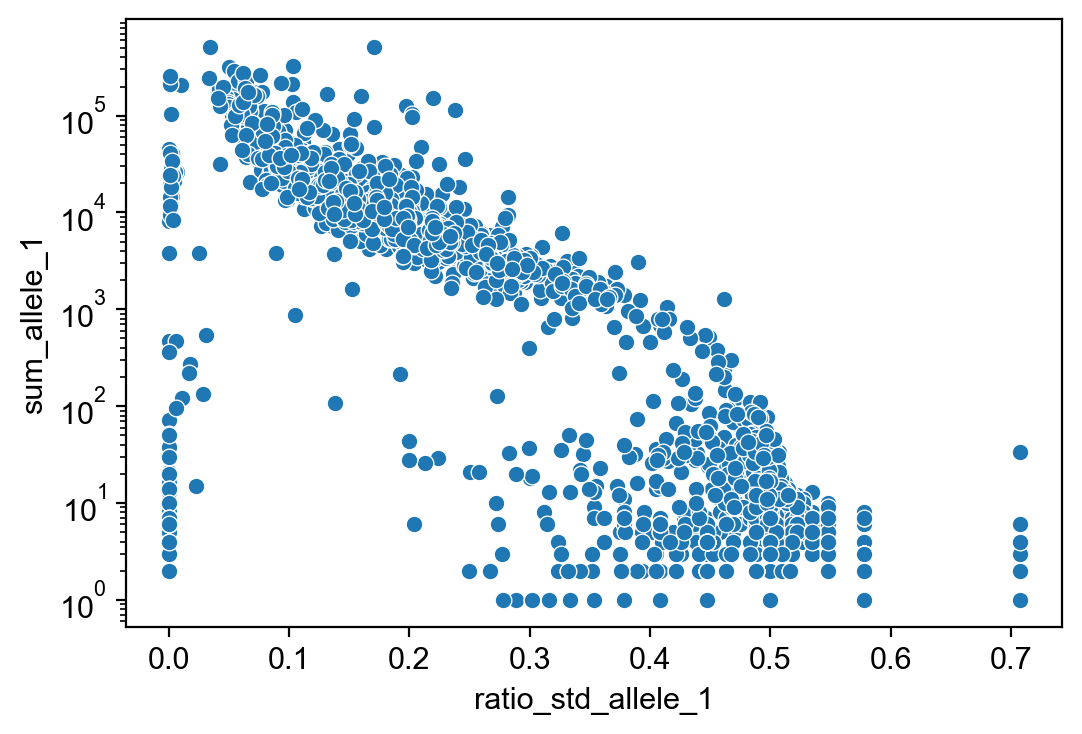

In [23]:
test.sns_scatter(x="ratio_std_allele_1", y="sum_allele_1", data=adata.var, is_log_scale = True)

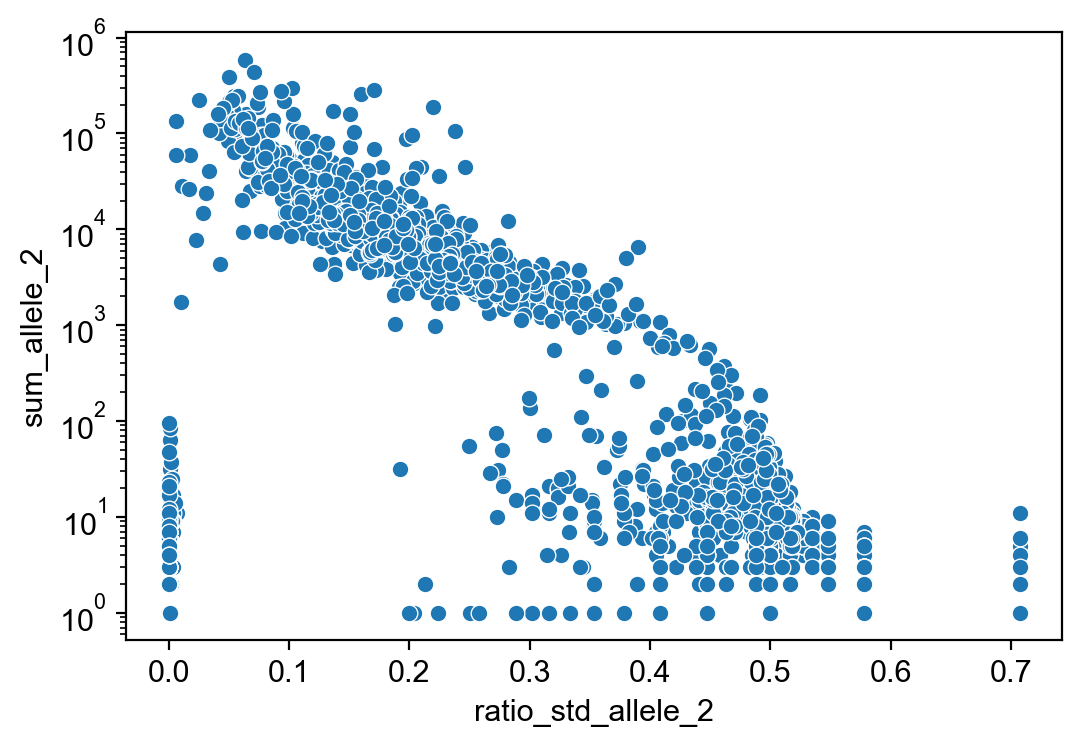

In [24]:
test.sns_scatter(x="ratio_std_allele_2", y="sum_allele_2", data=adata.var, is_log_scale = True)

In [25]:
df1 = adata.var[(adata.var['ratio_std_allele_1'] >= 0.4) & (adata.var['ratio_std_allele_1'] < 0.7) & (adata.var['sum_allele_1']> 100)]
df1

,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2
ENSMUSG00000001604,521.0,566.0,0.479301,0.520699,195.067677,188.932323,0.507989,0.492011,0.449131,0.449131
ENSMUSG00000006344,193.0,100.0,0.658703,0.341297,62.407720,27.592280,0.693419,0.306581,0.426229,0.426229
ENSMUSG00000019851,114.0,45.0,0.716981,0.283019,38.145455,12.854545,0.747950,0.252050,0.402051,0.402051
ENSMUSG00000021265,146.0,228.0,0.390374,0.609626,72.125000,122.875000,0.369872,0.630128,0.462348,0.462348
ENSMUSG00000021619,692.0,1082.0,0.390079,0.609921,202.195058,338.804942,0.373743,0.626257,0.408532,0.408532
ENSMUSG00000022195,798.0,598.0,0.571633,0.428367,295.888672,240.111328,0.552031,0.447969,0.406808,0.406808
ENSMUSG00000023336,121.0,195.0,0.382911,0.617089,41.322939,61.677061,0.401194,0.598806,0.471621,0.471621
ENSMUSG00000026196,106.0,117.0,0.475336,0.524664,55.100000,57.900000,0.487611,0.512389,0.434075,0.434075
ENSMUSG00000026574,238.0,187.0,0.560000,0.440000,65.880784,48.119216,0.577902,0.422098,0.461072,0.461072
ENSMUSG00000027188,122.0,216.0,0.360947,0.639053,23.624128,40.375872,0.369127,0.630873,0.437321,0.437321


In [26]:
df2 = adata.var[(adata.var['ratio_std_allele_2'] >= 0.4) & (adata.var['ratio_std_allele_2'] < 0.7) & (adata.var['sum_allele_2']> 100)]
df2

,sum_allele_1,sum_allele_2,ratio_allele_1,ratio_allele_2,ratio_sum_allele_1,ratio_sum_allele_2,ratio_mean_allele_1,ratio_mean_allele_2,ratio_std_allele_1,ratio_std_allele_2
ENSMUSG00000001604,521.0,566.0,0.479301,0.520699,195.067677,188.932323,0.507989,0.492011,0.449131,0.449131
ENSMUSG00000021265,146.0,228.0,0.390374,0.609626,72.125000,122.875000,0.369872,0.630128,0.462348,0.462348
ENSMUSG00000021619,692.0,1082.0,0.390079,0.609921,202.195058,338.804942,0.373743,0.626257,0.408532,0.408532
ENSMUSG00000022195,798.0,598.0,0.571633,0.428367,295.888672,240.111328,0.552031,0.447969,0.406808,0.406808
ENSMUSG00000023336,121.0,195.0,0.382911,0.617089,41.322939,61.677061,0.401194,0.598806,0.471621,0.471621
ENSMUSG00000026196,106.0,117.0,0.475336,0.524664,55.100000,57.900000,0.487611,0.512389,0.434075,0.434075
ENSMUSG00000026574,238.0,187.0,0.560000,0.440000,65.880784,48.119216,0.577902,0.422098,0.461072,0.461072
ENSMUSG00000027188,122.0,216.0,0.360947,0.639053,23.624128,40.375872,0.369127,0.630873,0.437321,0.437321
ENSMUSG00000027220,69.0,112.0,0.381215,0.618785,24.856349,30.143651,0.451934,0.548066,0.468538,0.468538
ENSMUSG00000029409,1268.0,374.0,0.772229,0.227771,118.168778,92.831222,0.560042,0.439958,0.461318,0.461318


In [27]:
selected_genes3 = list(df1.index)
selected_genes3

['ENSMUSG00000001604',
 'ENSMUSG00000006344',
 'ENSMUSG00000019851',
 'ENSMUSG00000021265',
 'ENSMUSG00000021619',
 'ENSMUSG00000022195',
 'ENSMUSG00000023336',
 'ENSMUSG00000026196',
 'ENSMUSG00000026574',
 'ENSMUSG00000027188',
 'ENSMUSG00000029409',
 'ENSMUSG00000030284',
 'ENSMUSG00000035473',
 'ENSMUSG00000039232',
 'ENSMUSG00000040557',
 'ENSMUSG00000042834',
 'ENSMUSG00000049411',
 'ENSMUSG00000050931',
 'ENSMUSG00000053181',
 'ENSMUSG00000062944',
 'ENSMUSG00000065564',
 'ENSMUSG00000065589',
 'ENSMUSG00000066278',
 'ENSMUSG00000074211',
 'ENSMUSG00000078768',
 'ENSMUSG00000083816',
 'ENSMUSG00000085379',
 'ENSMUSG00000086413',
 'ENSMUSG00000093314',
 'ENSMUSG00000104686',
 'ENSMUSG00000111511',
 'ENSMUSG00000115049']

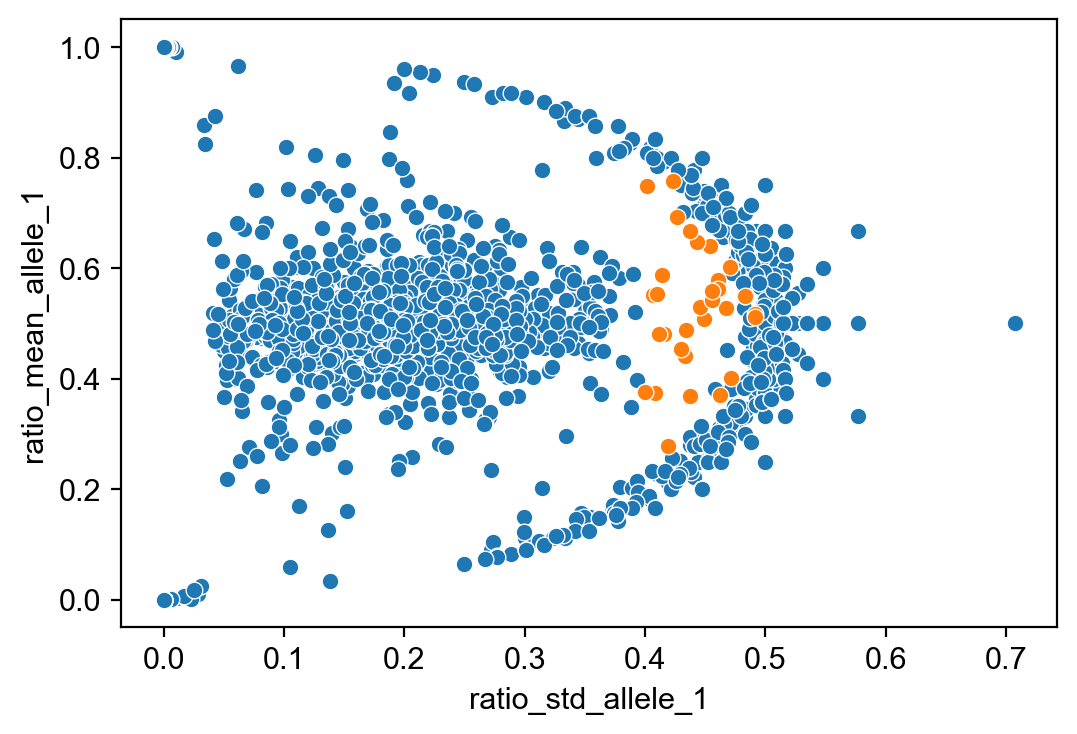

In [28]:
test.sns_scatter(x="ratio_std_allele_1", y="ratio_mean_allele_1", data=adata.var, selected_genes=selected_genes3)

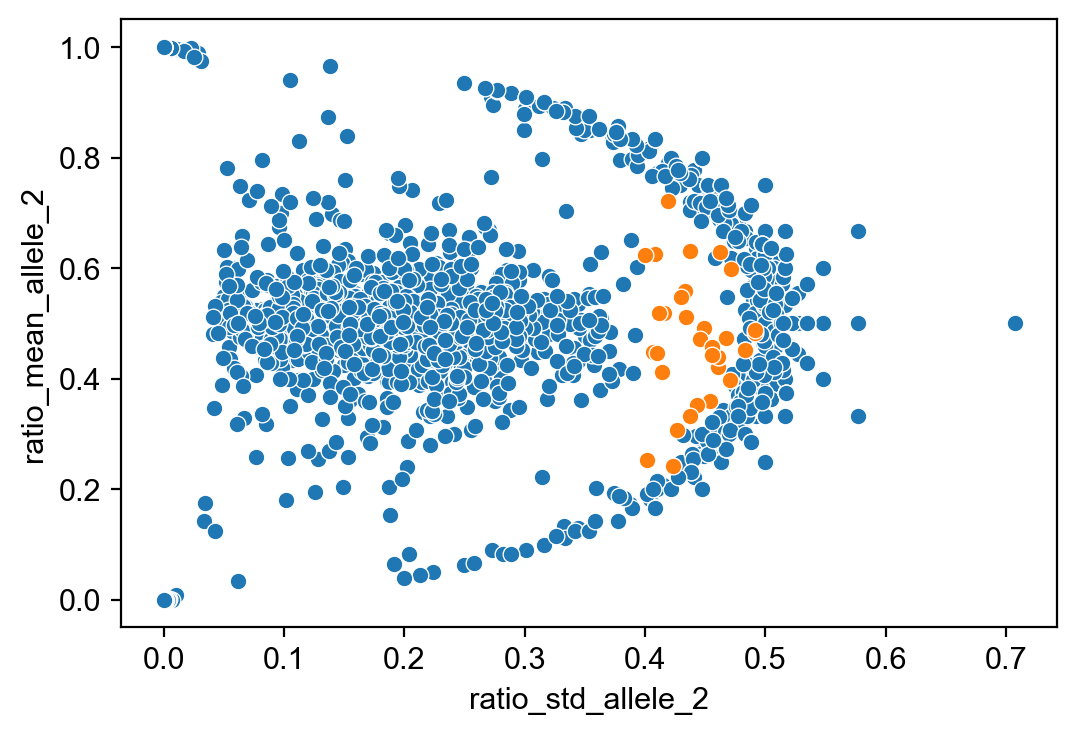

In [29]:
test.sns_scatter(x="ratio_std_allele_2", y="ratio_mean_allele_2", data=adata.var, selected_genes=selected_genes3)

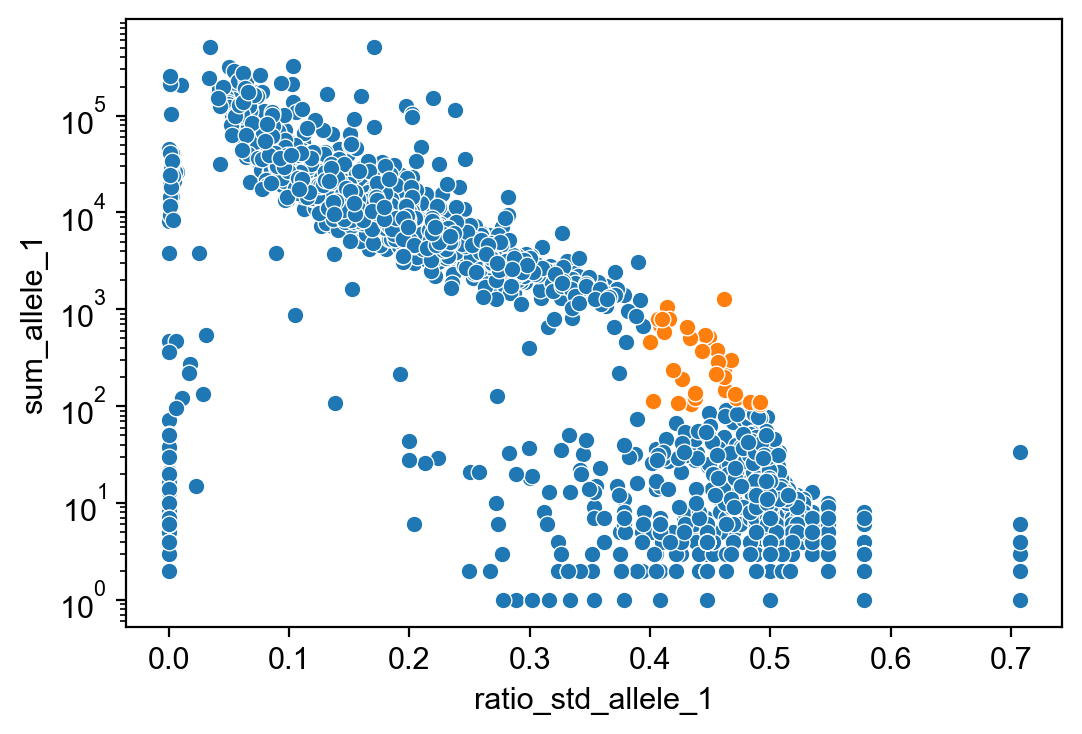

In [30]:
test.sns_scatter(x="ratio_std_allele_1", y="sum_allele_1", data=adata.var, is_log_scale = True, selected_genes=selected_genes3)

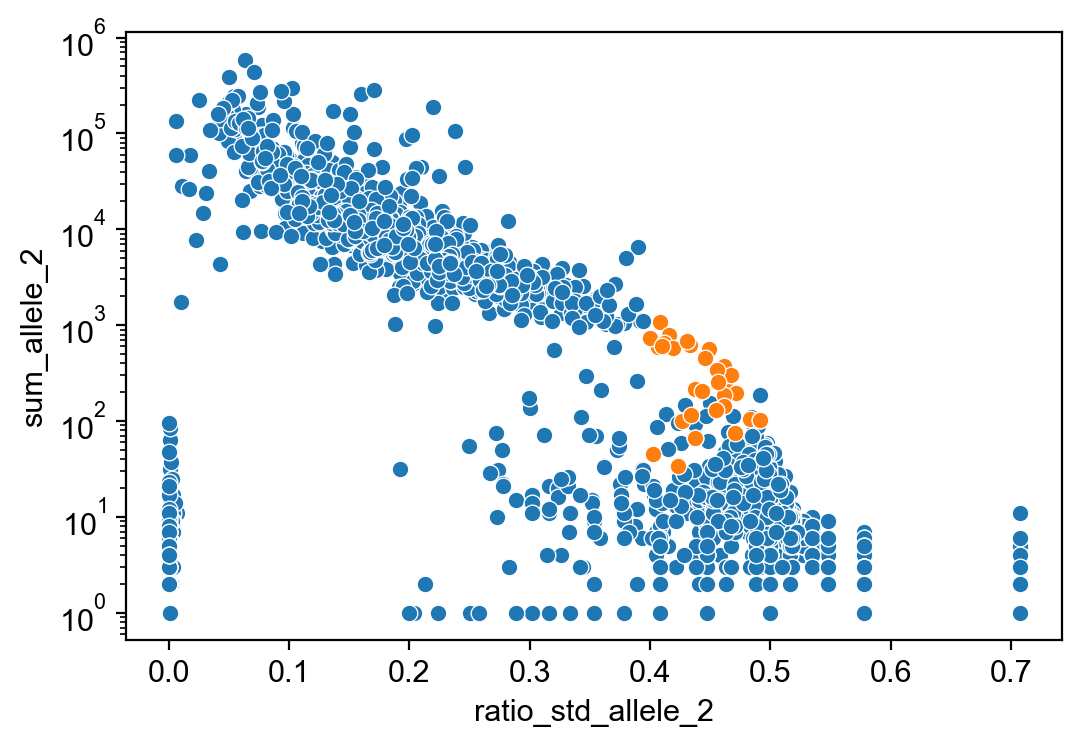

In [43]:
test.sns_scatter(x="ratio_std_allele_2", y="sum_allele_2", data=adata.var, is_log_scale = True, selected_genes=selected_genes3)

In [31]:
# adata.write("data/with_std.h5ad")

In [32]:
sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['clusters'] = adata.obs['leiden'].copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


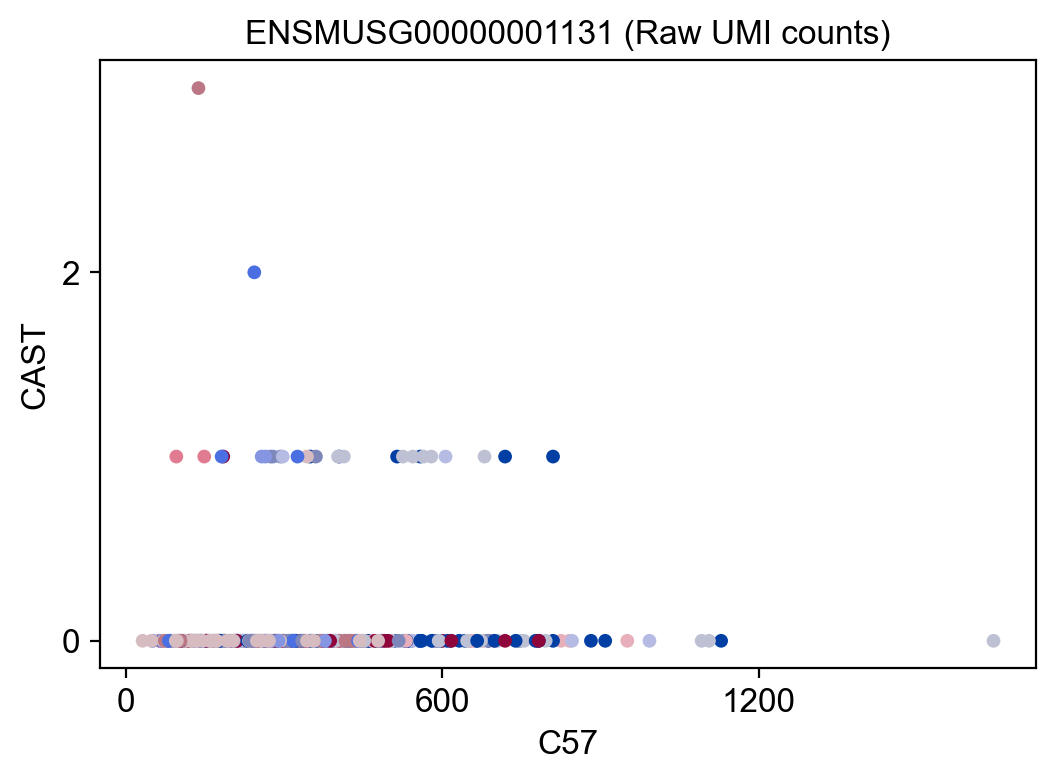

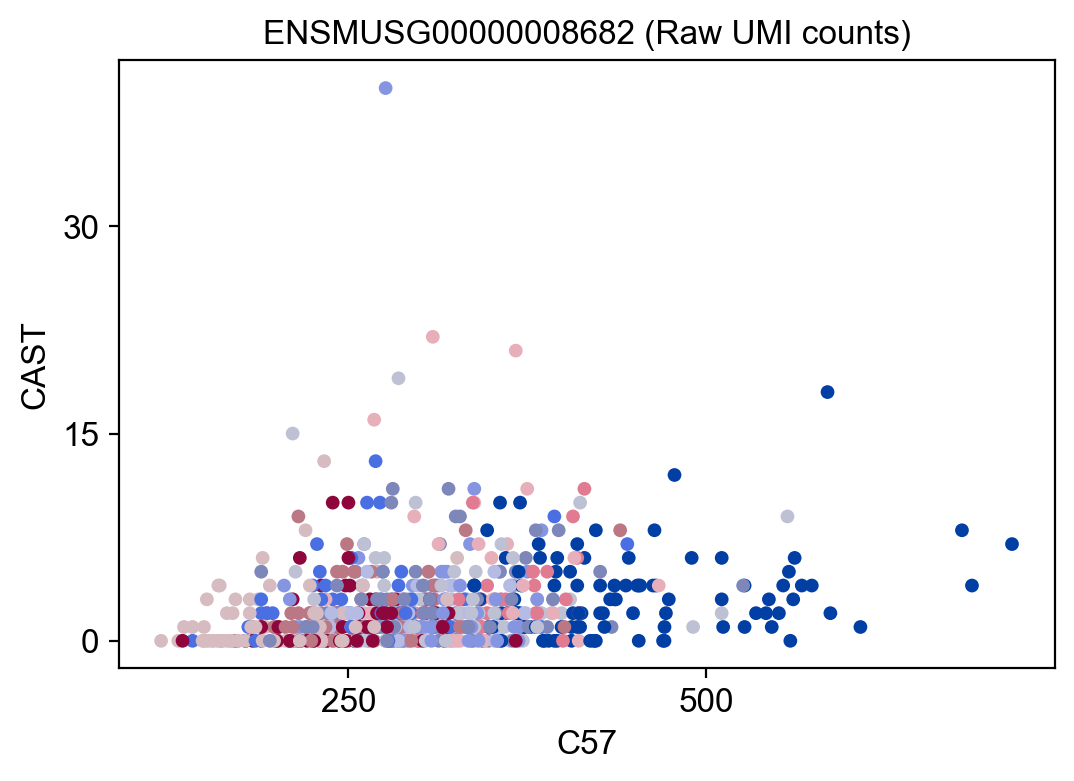

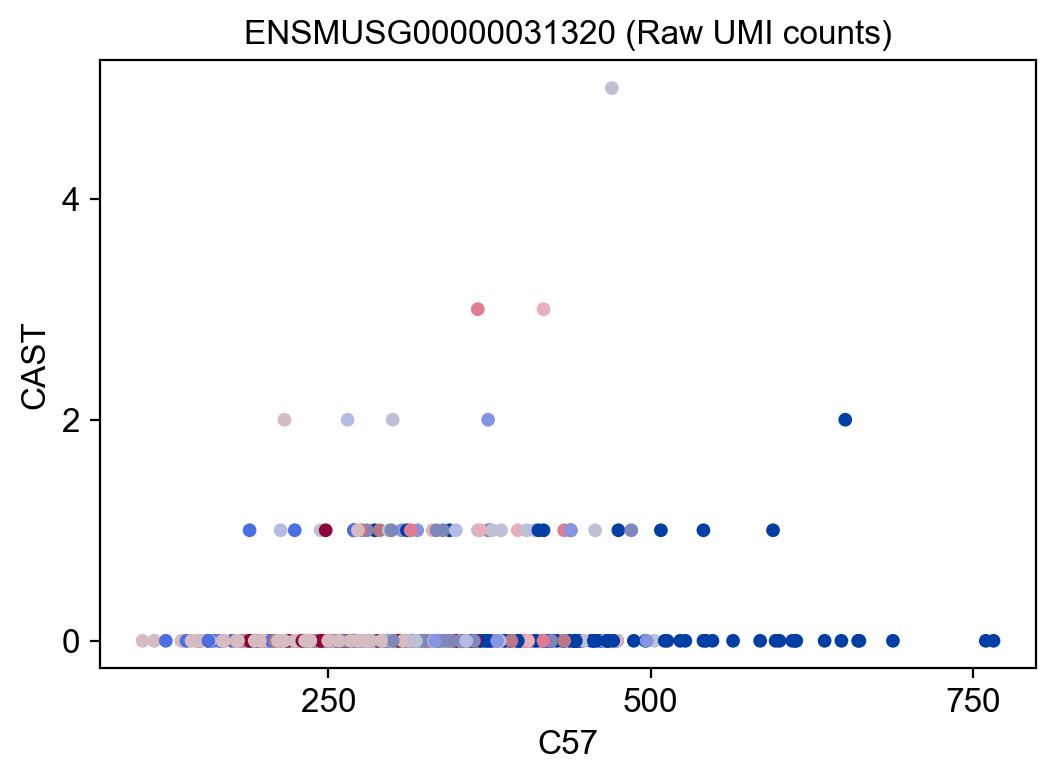

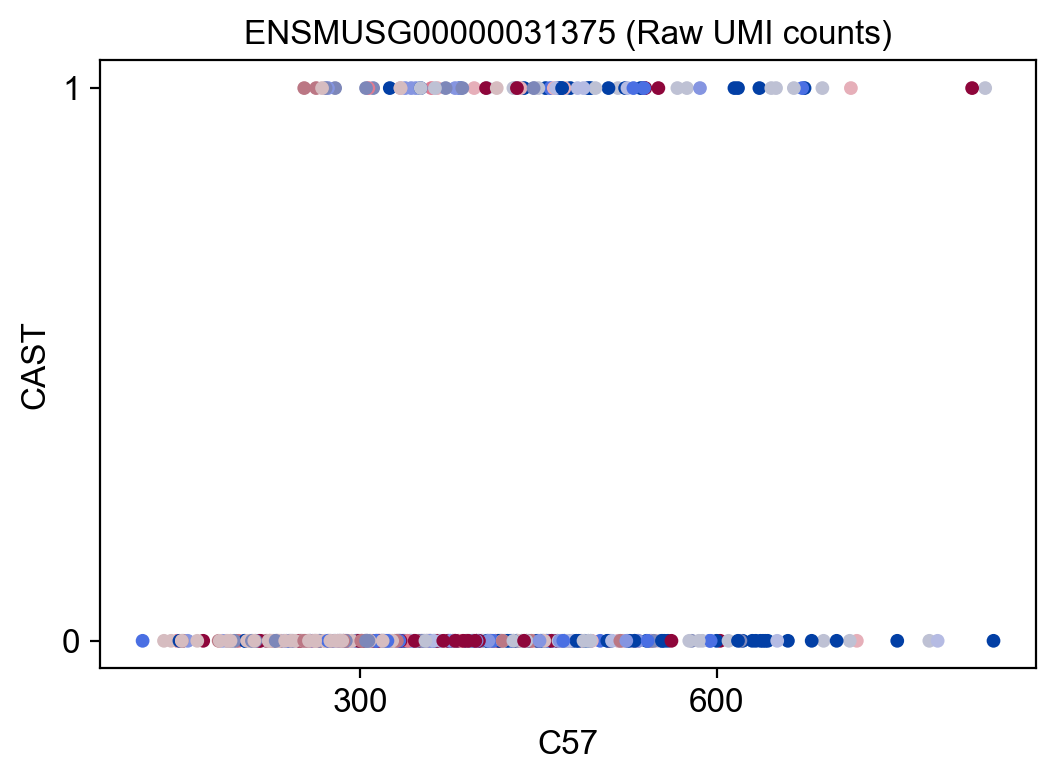

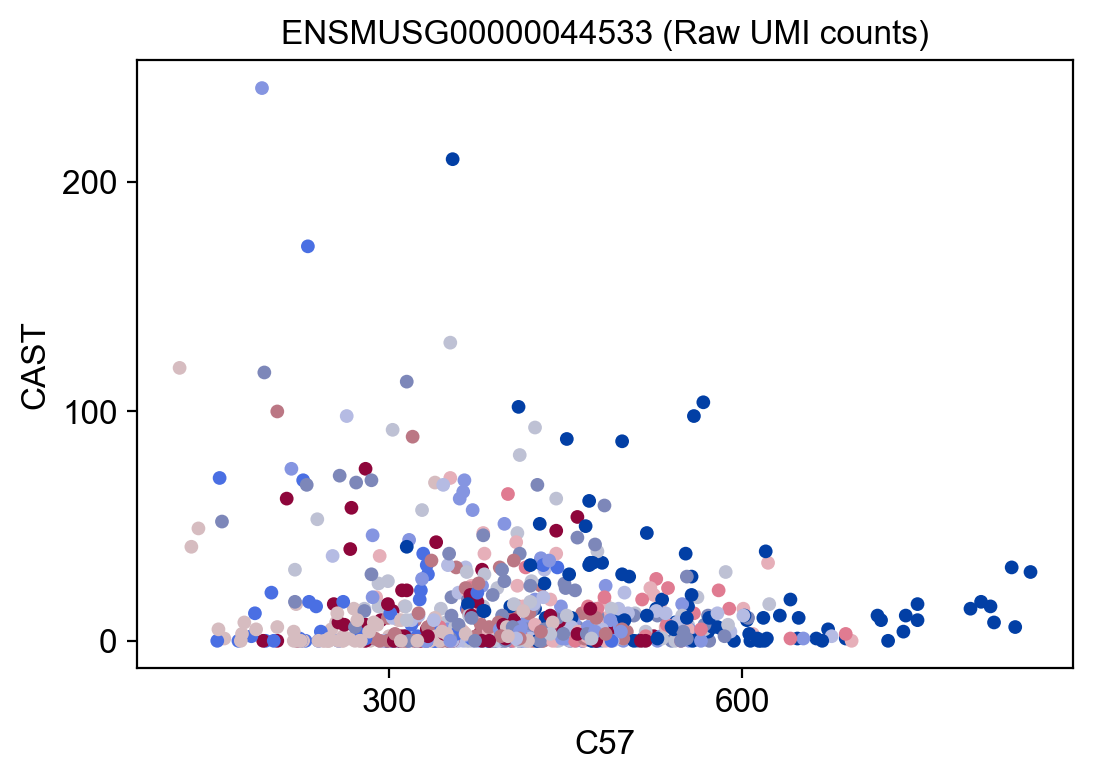

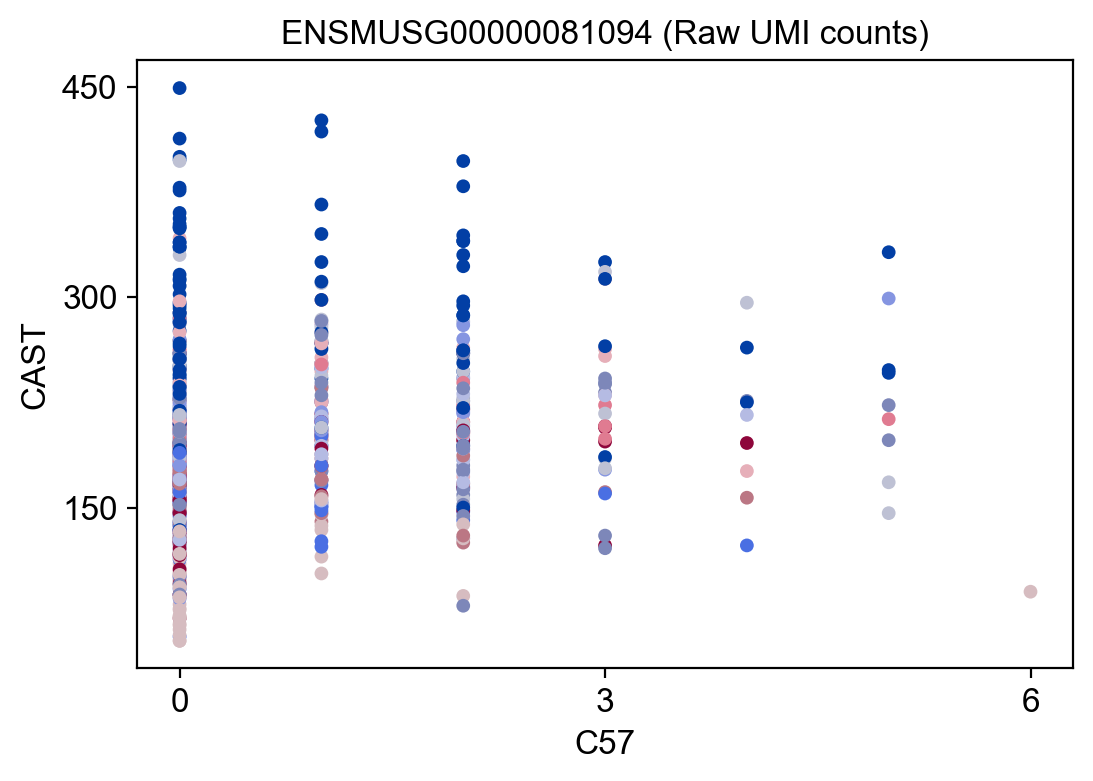

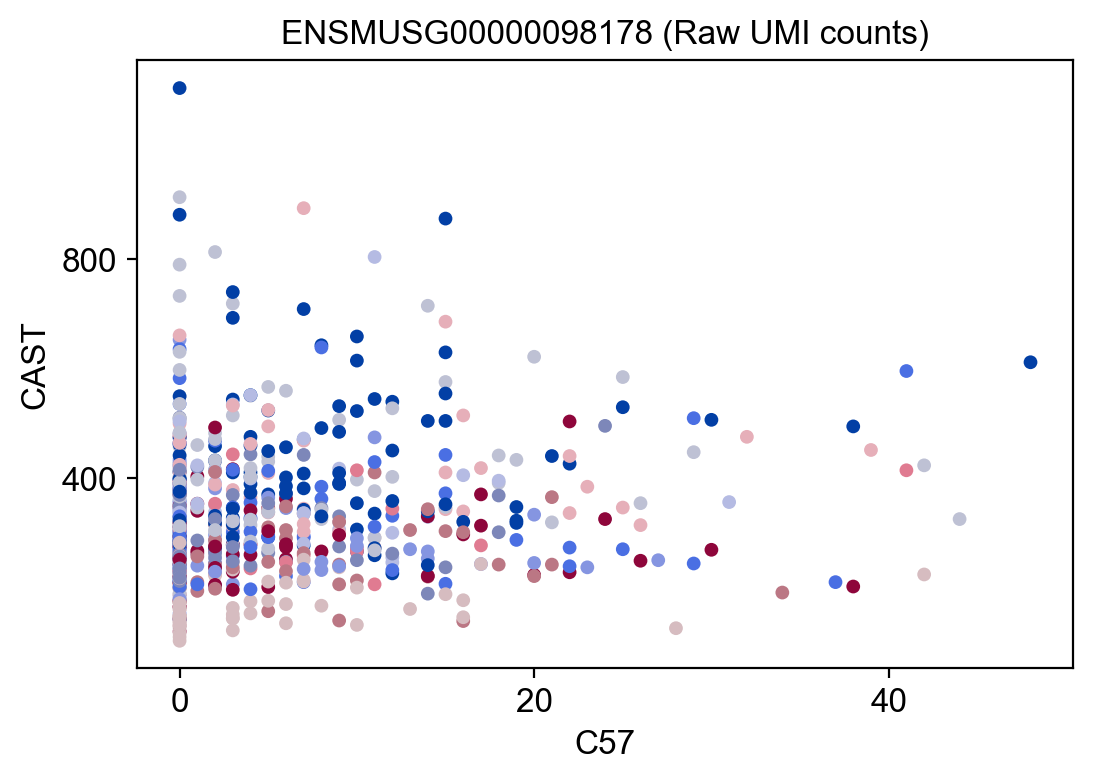

In [33]:
count = 1
for x in selected_genes:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'],
                       xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts)")
        count += 1

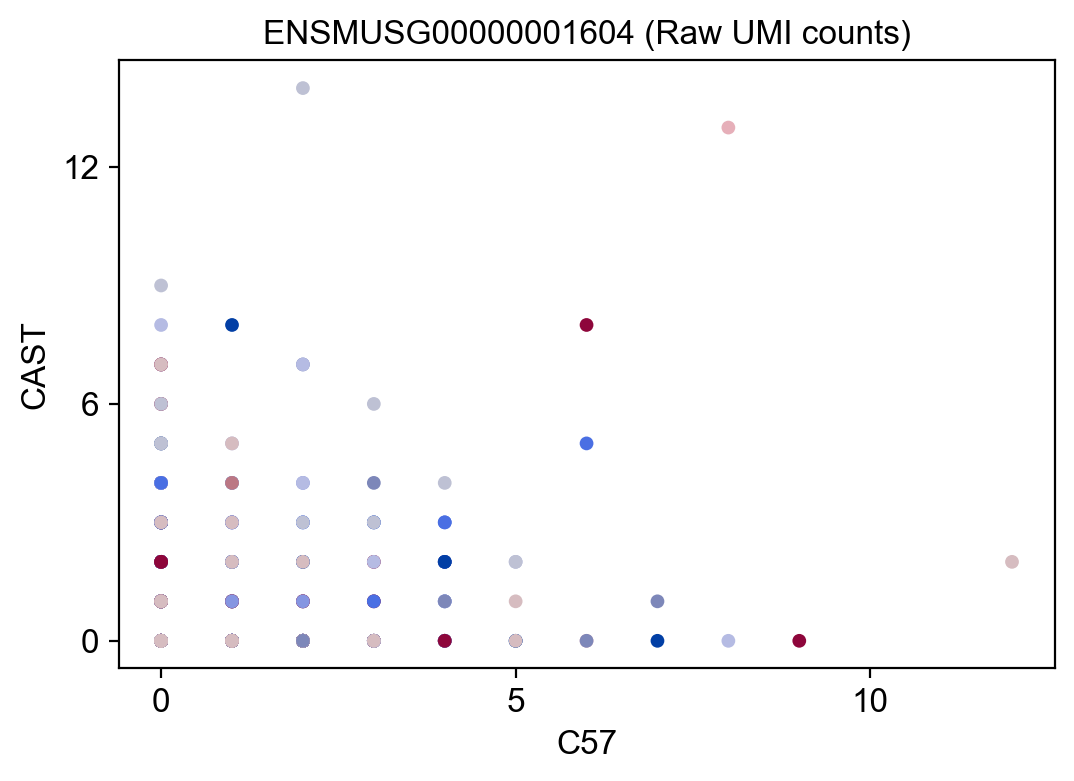

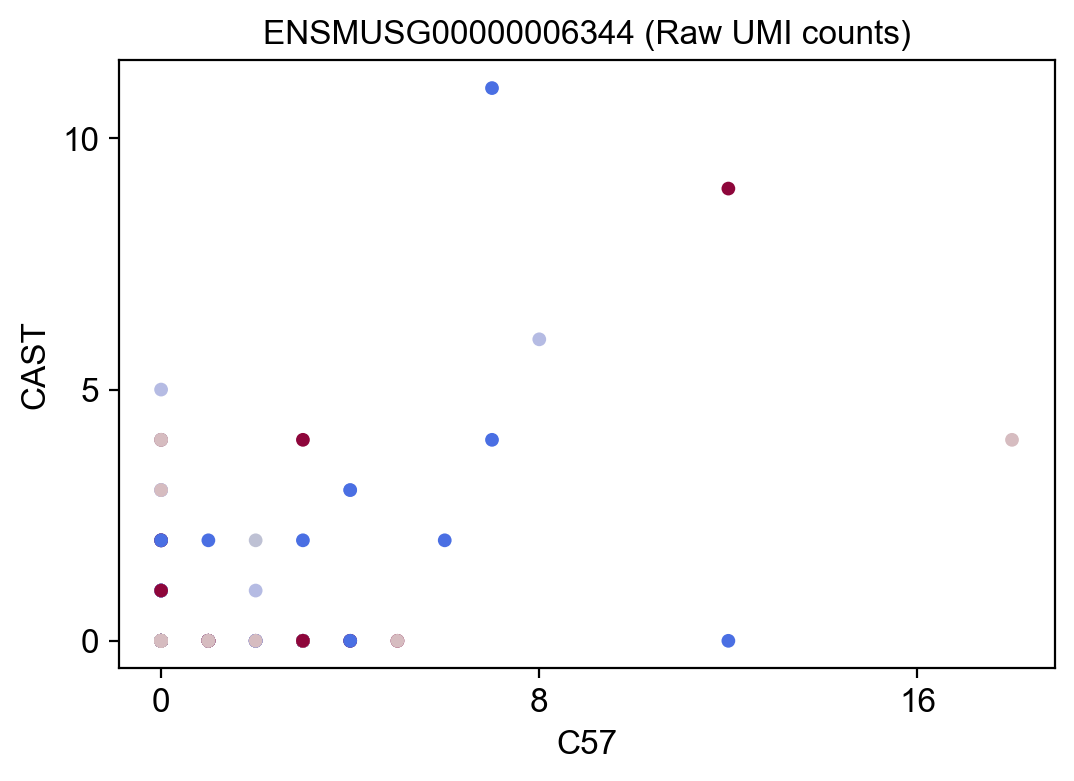

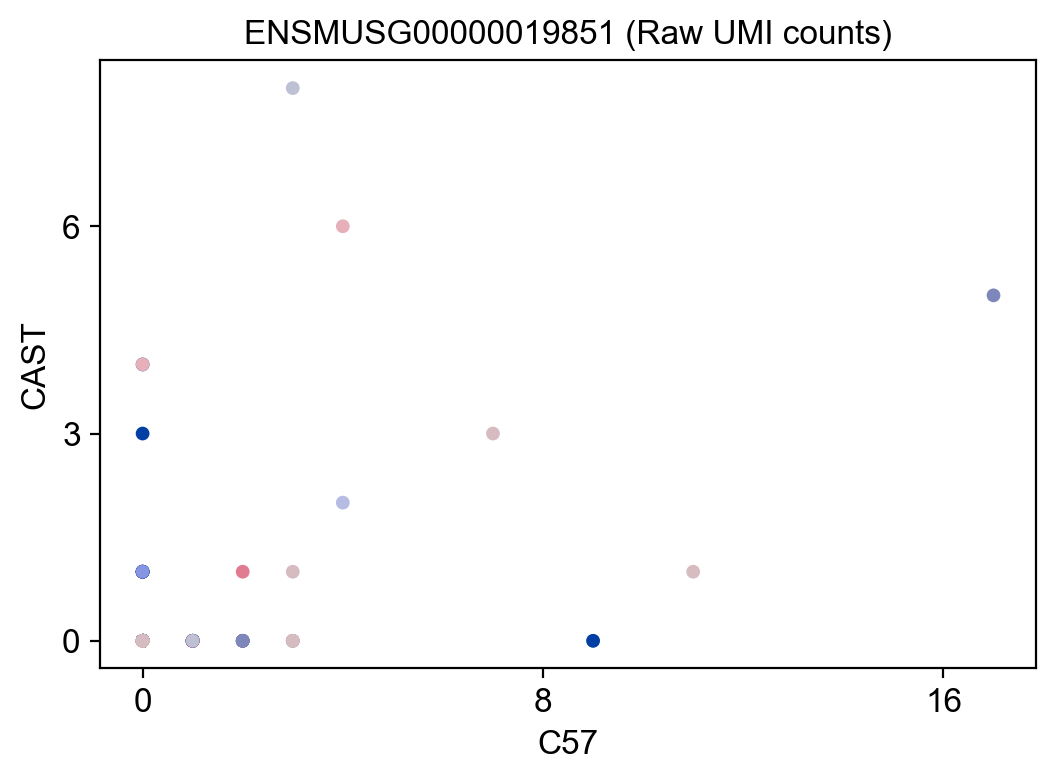

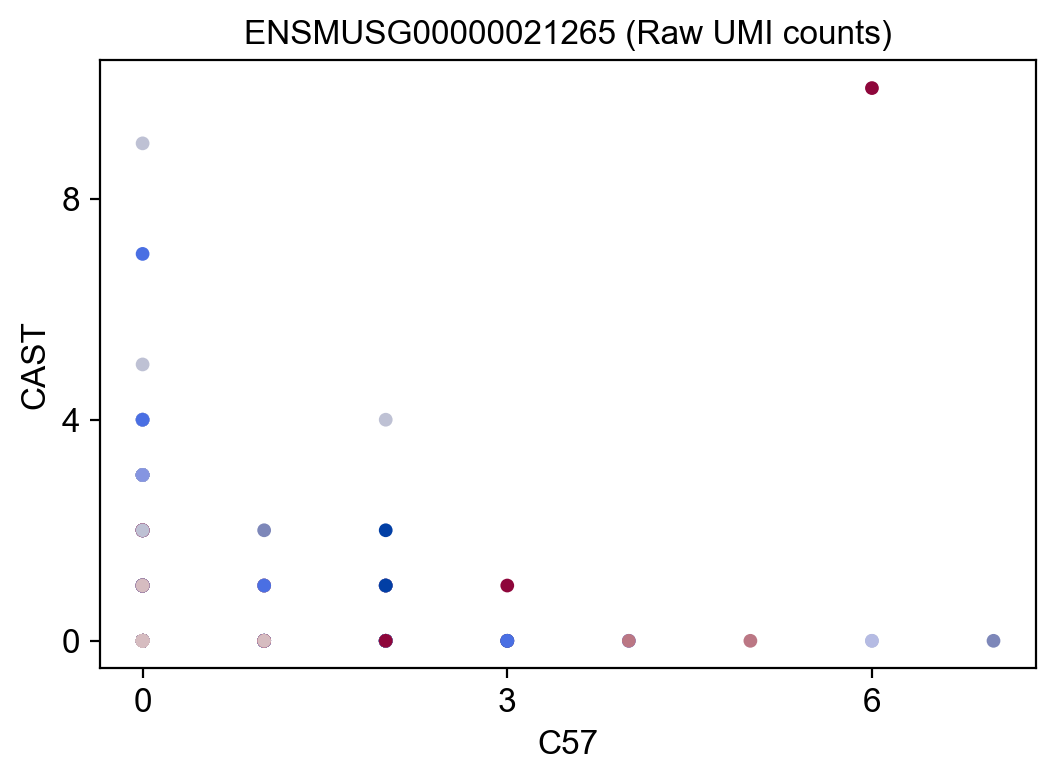

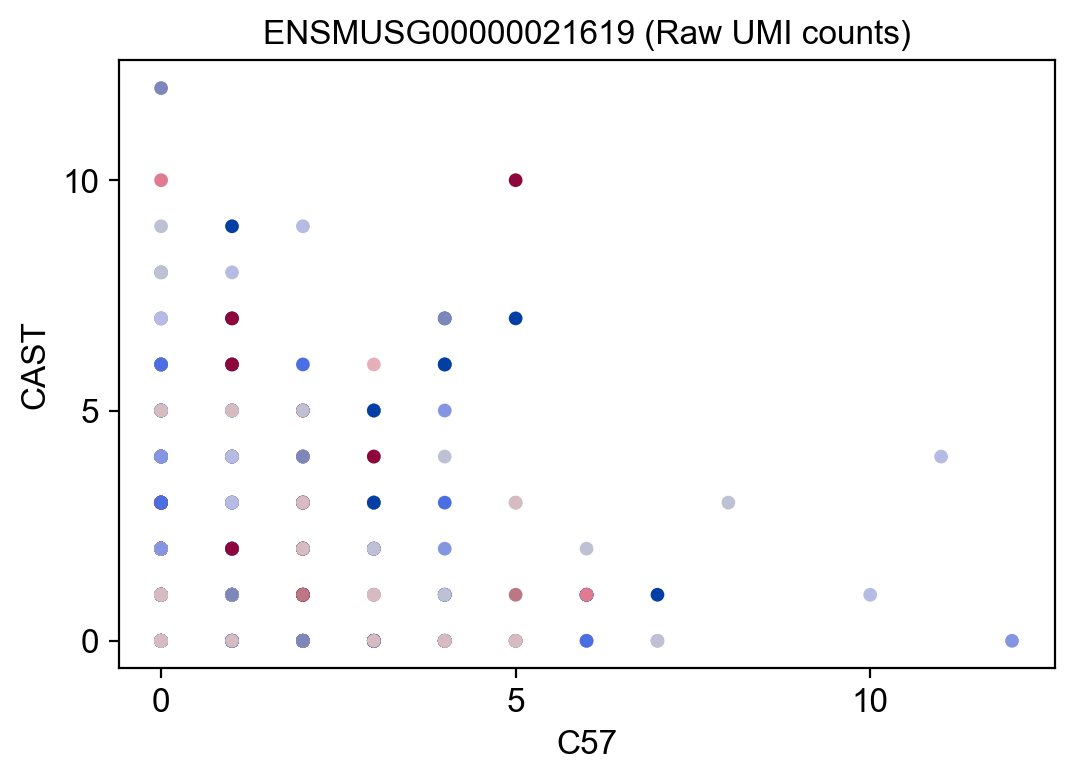

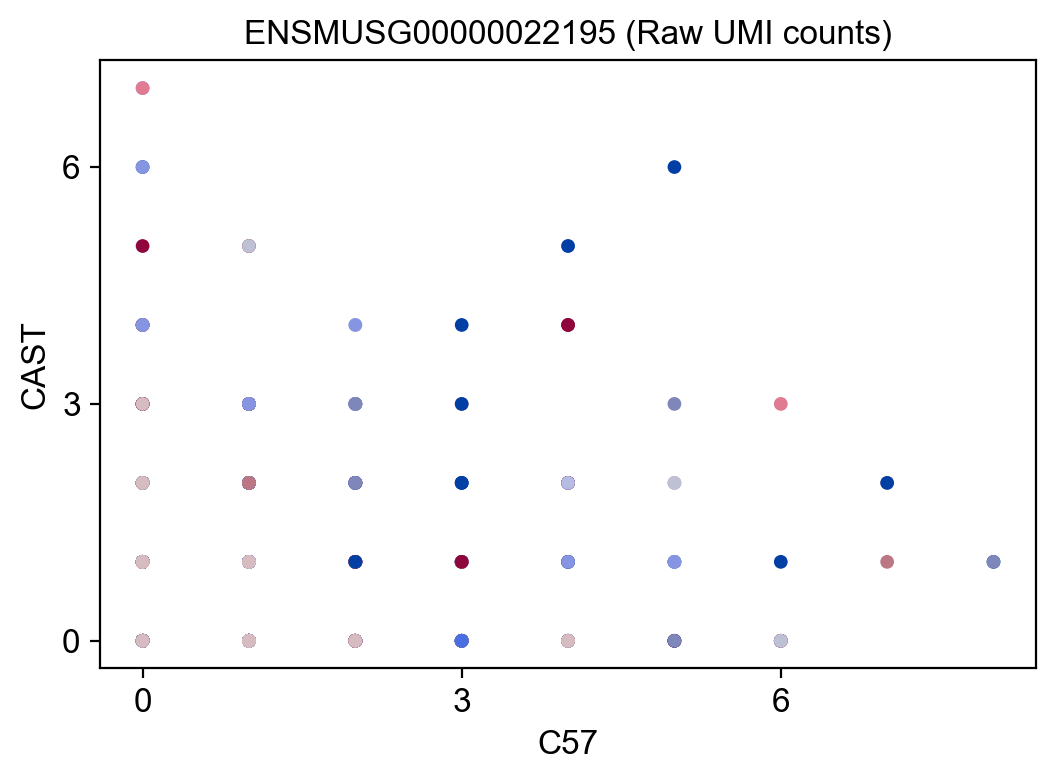

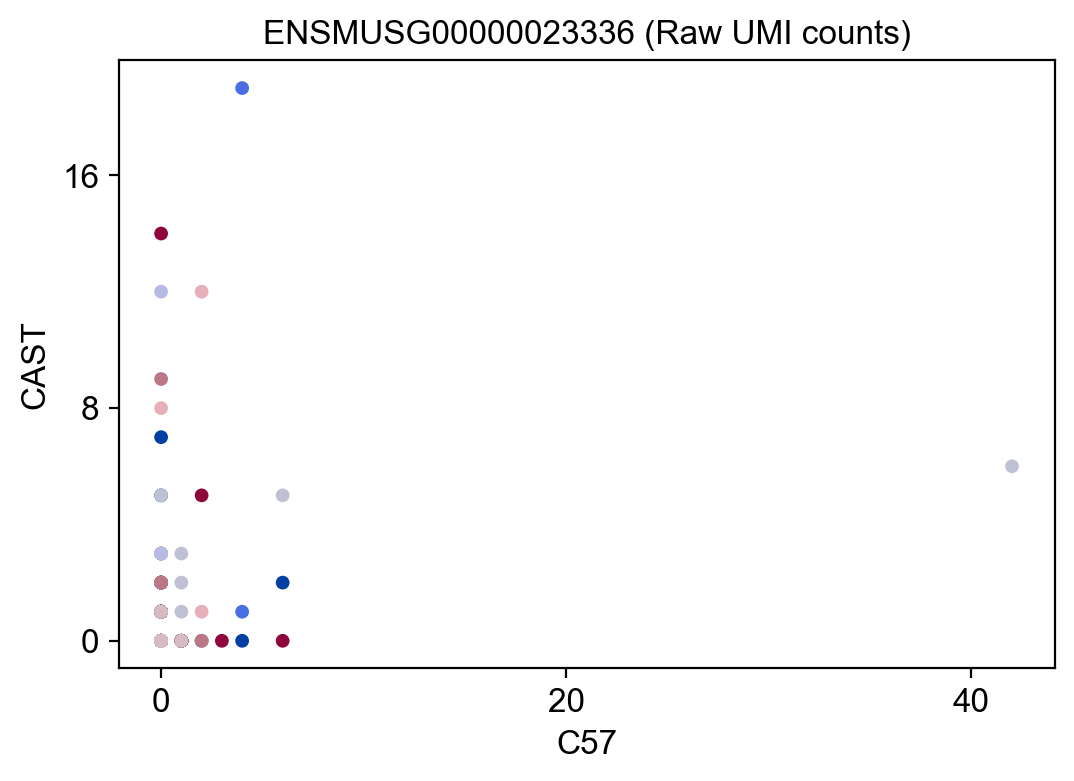

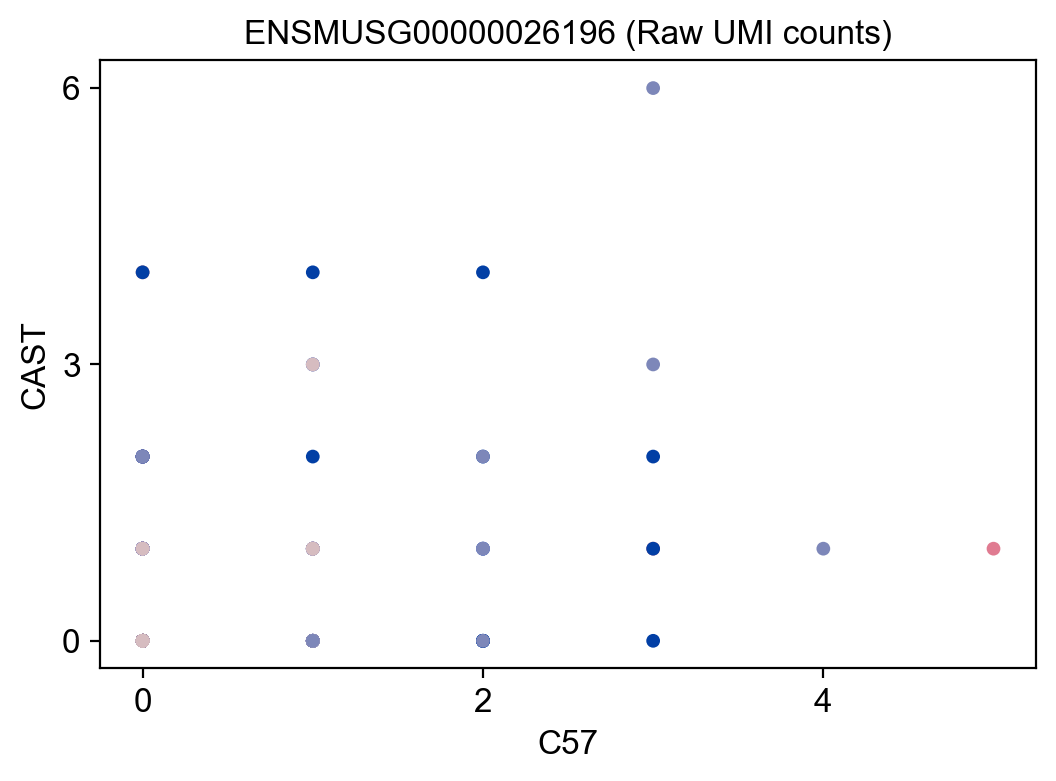

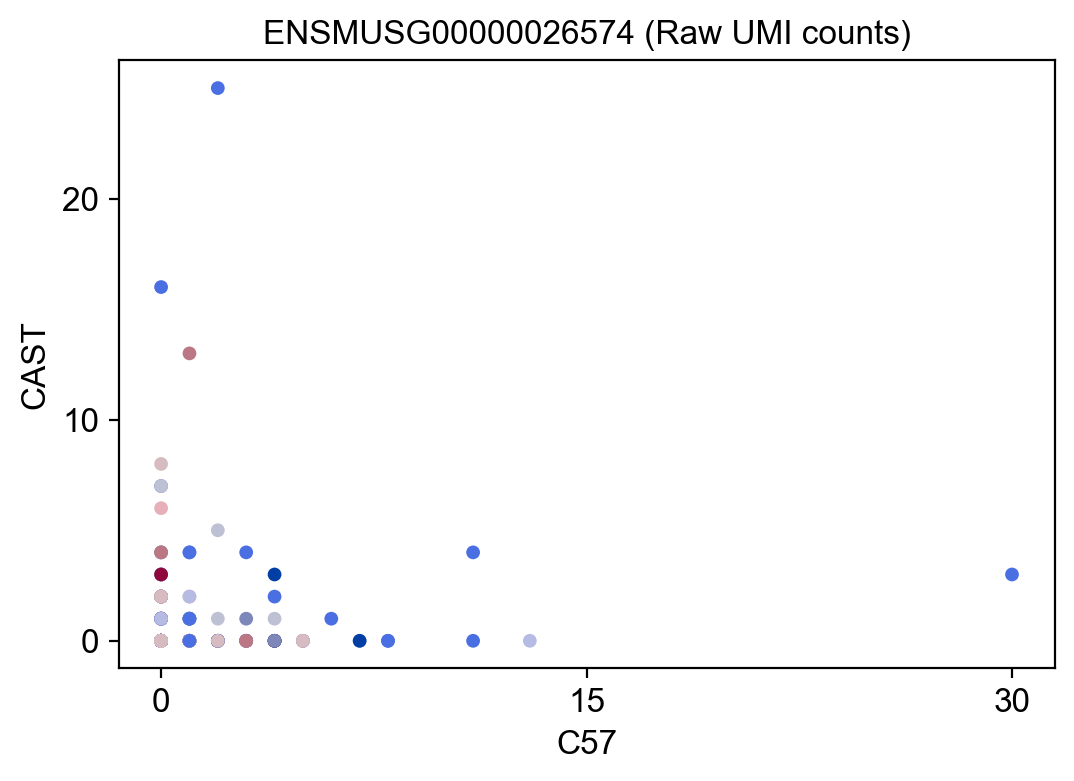

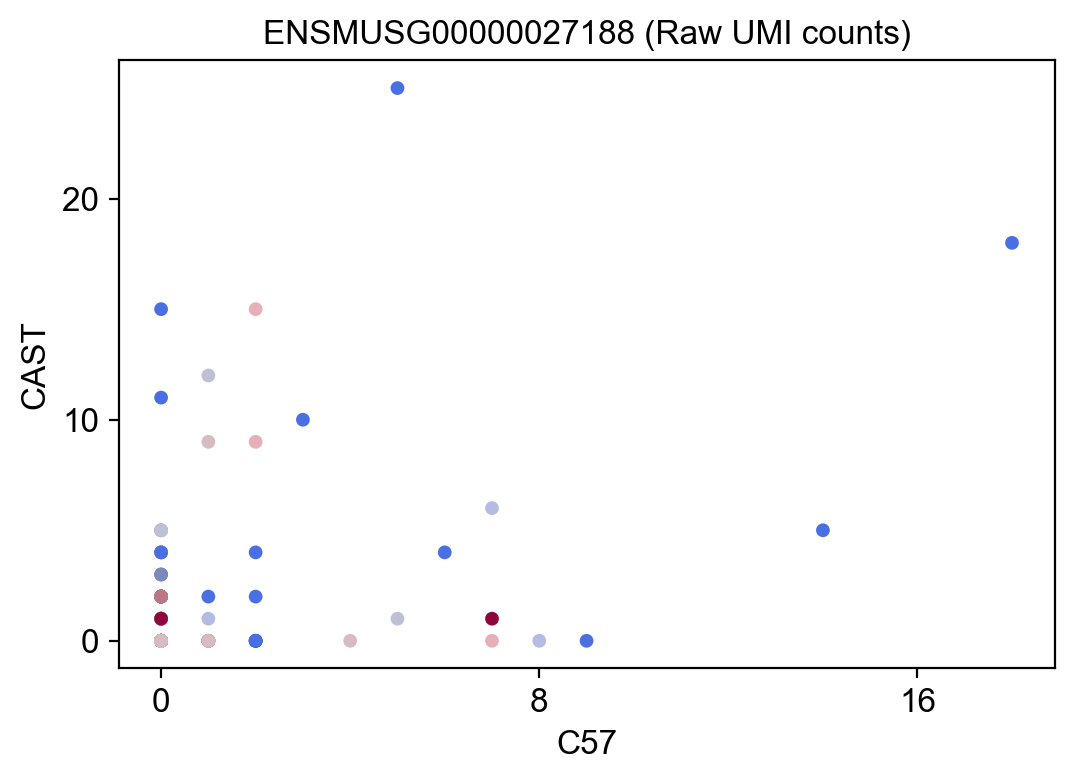

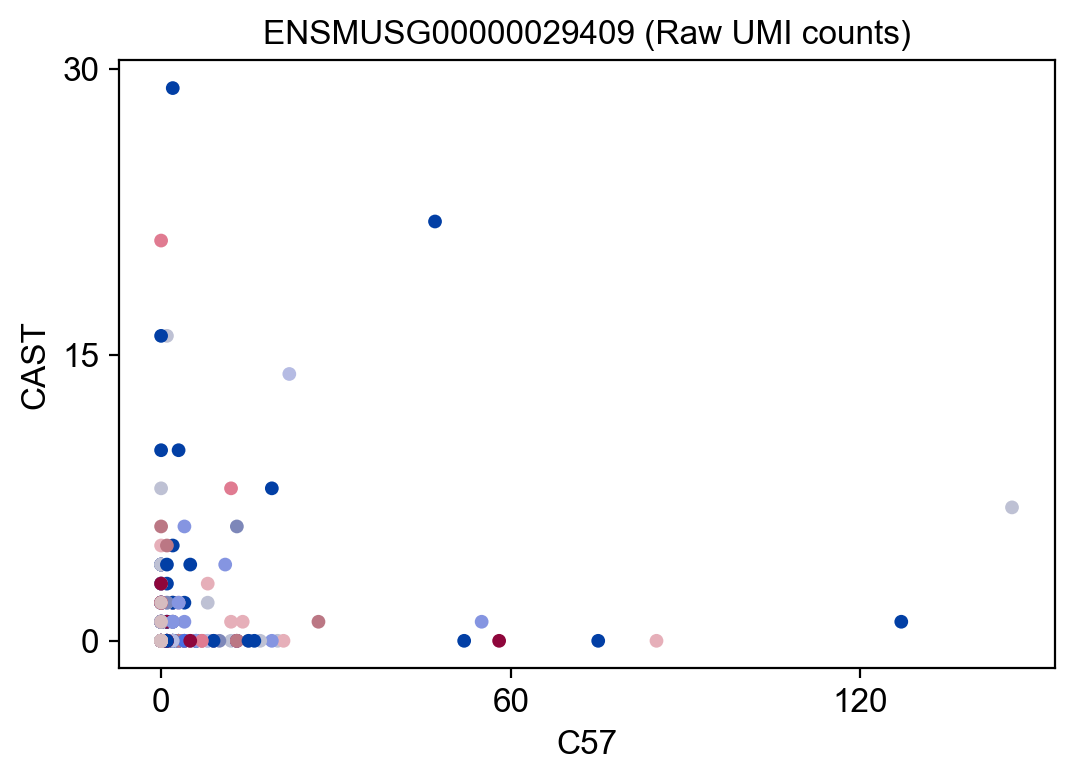

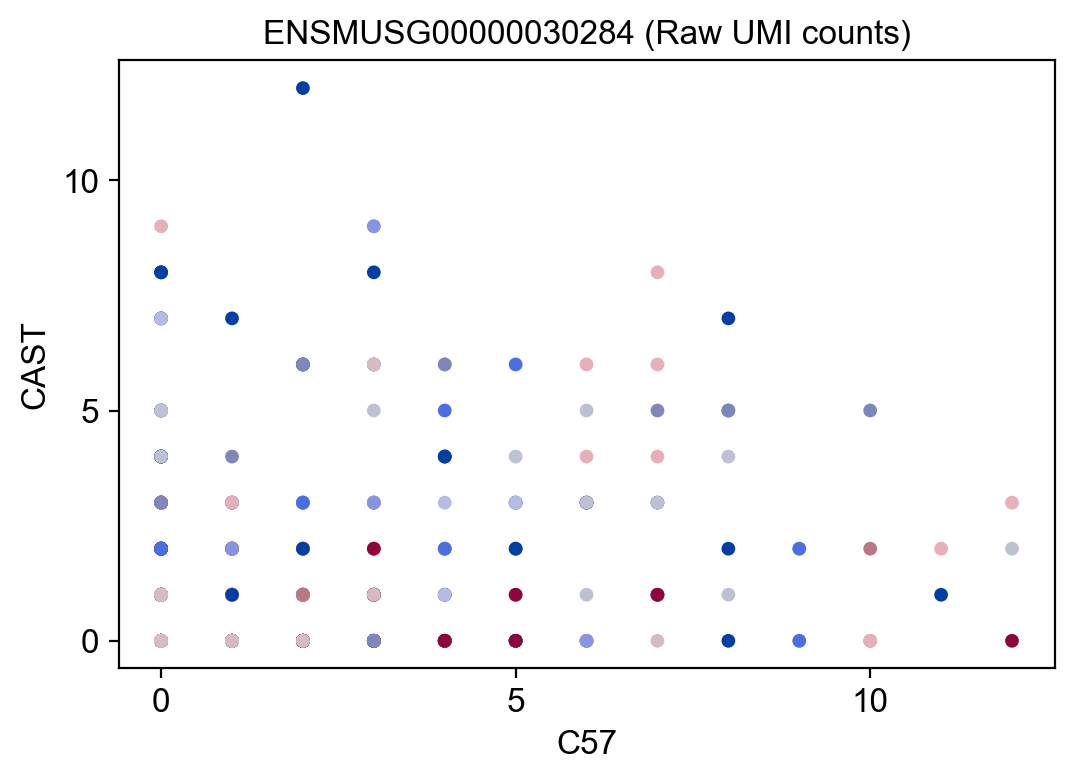

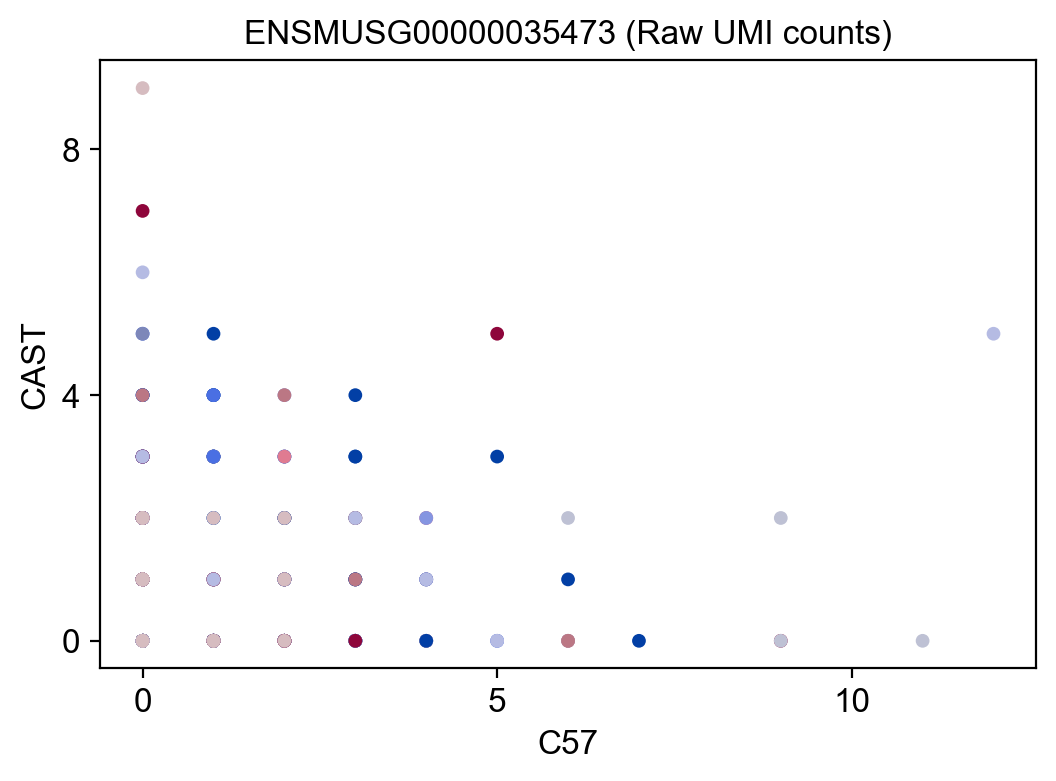

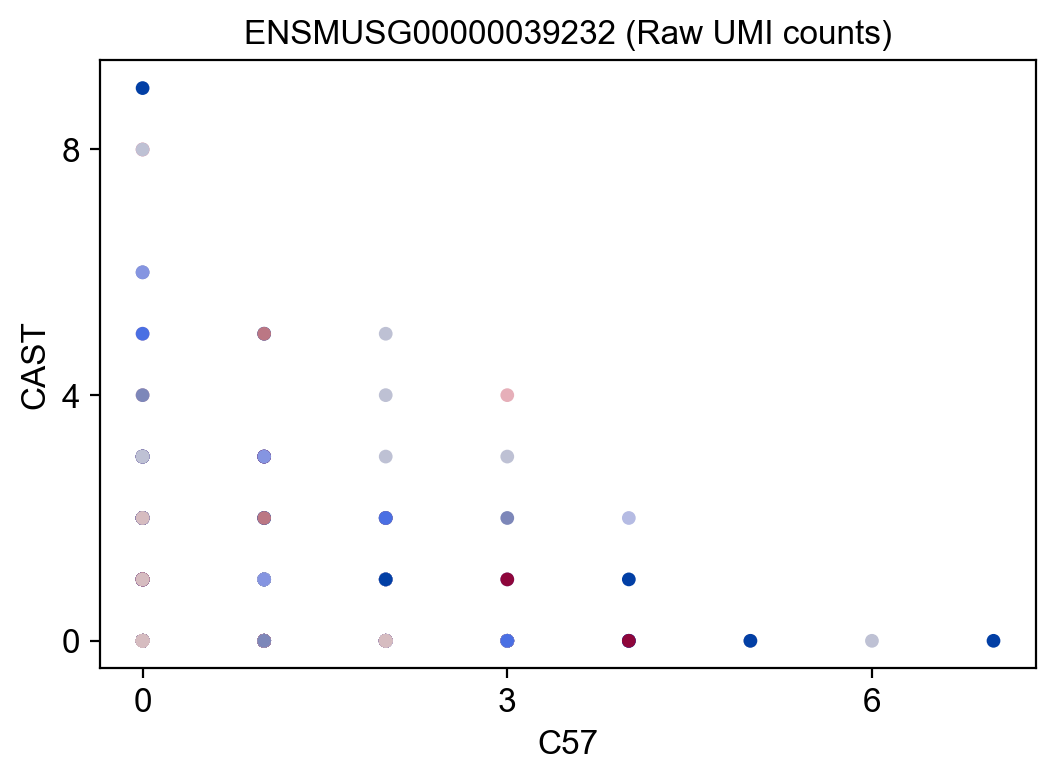

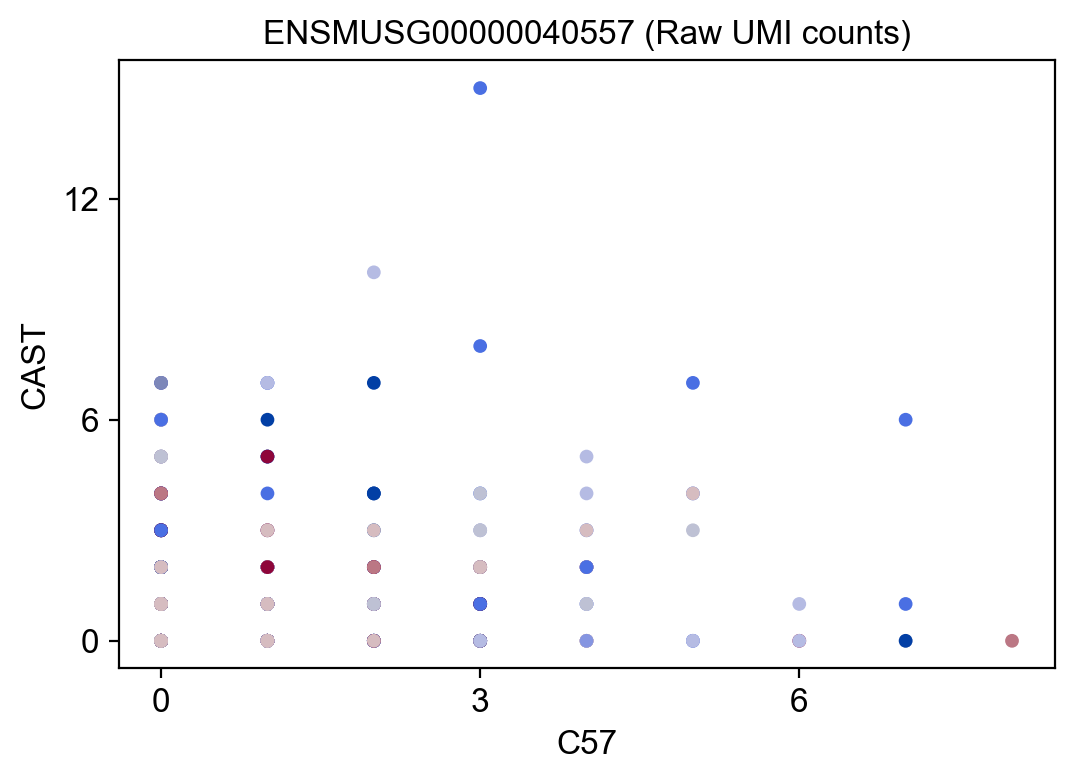

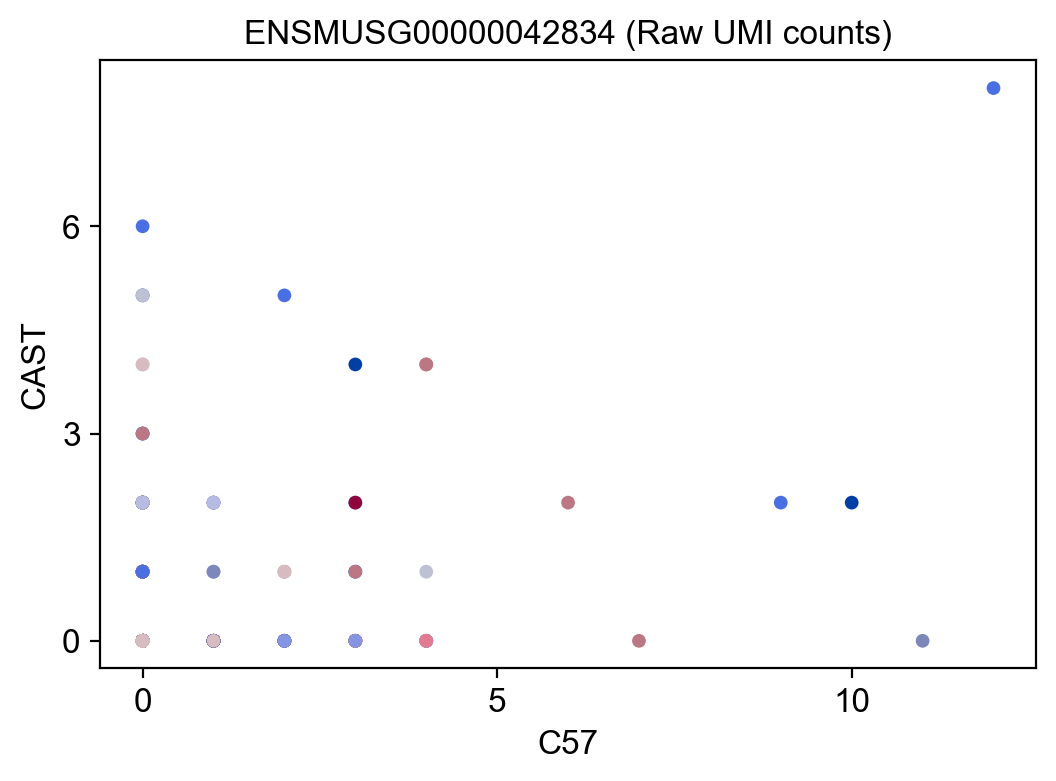

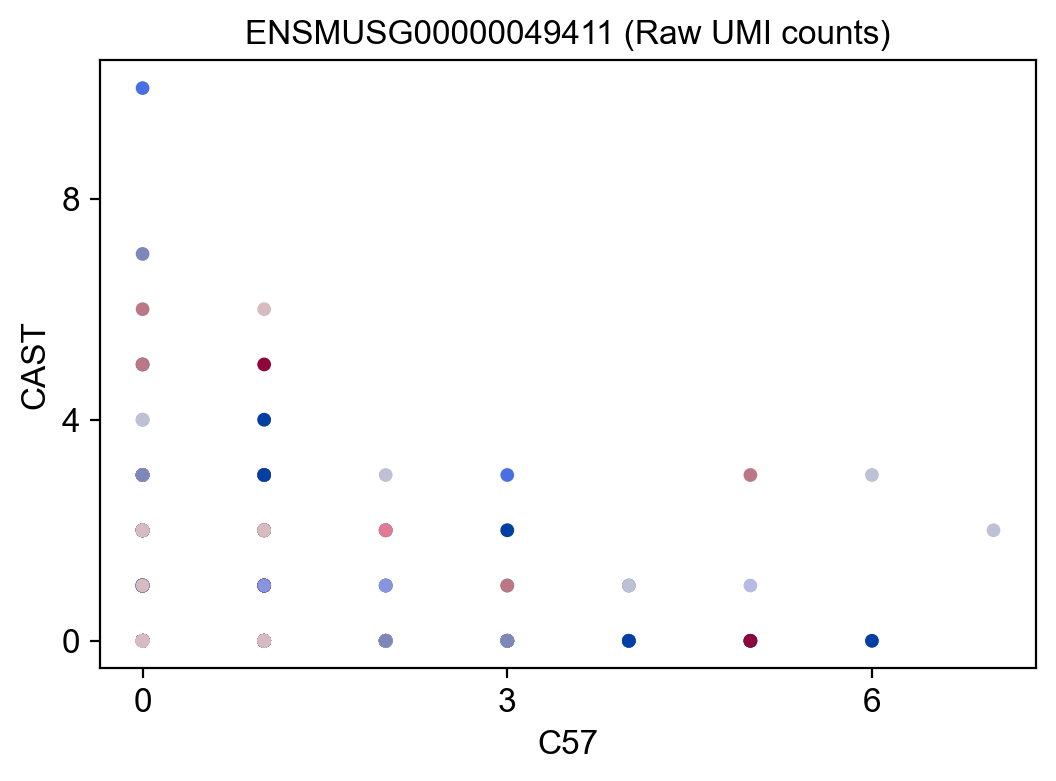

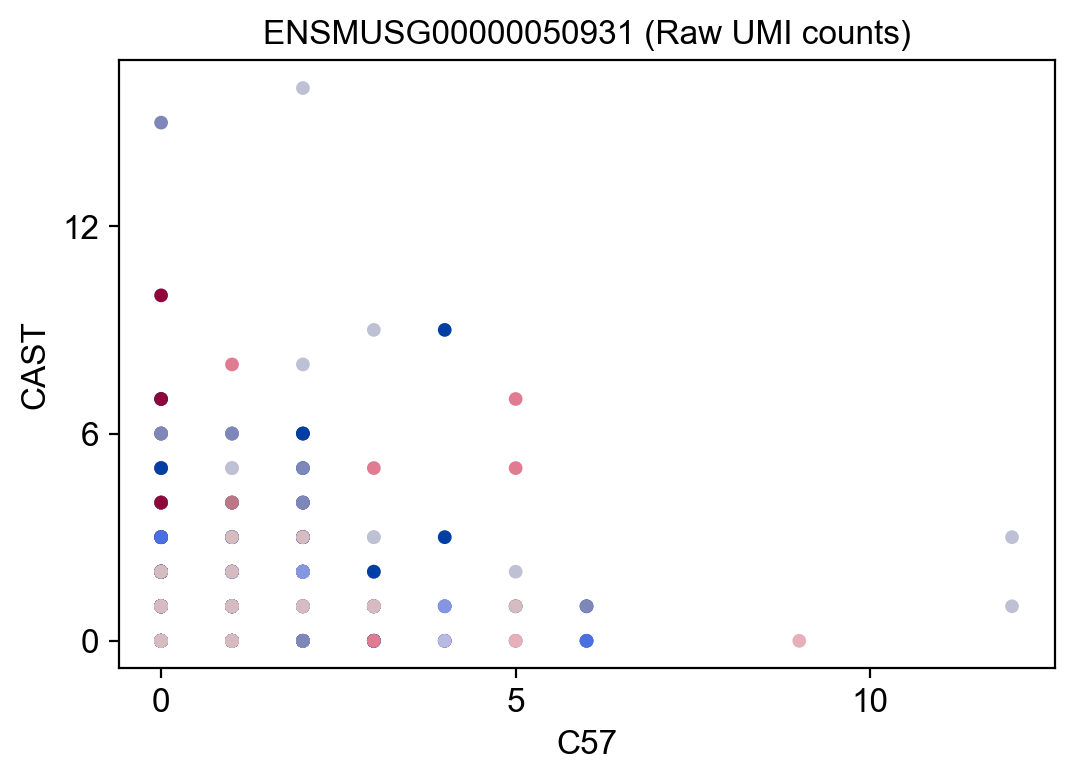

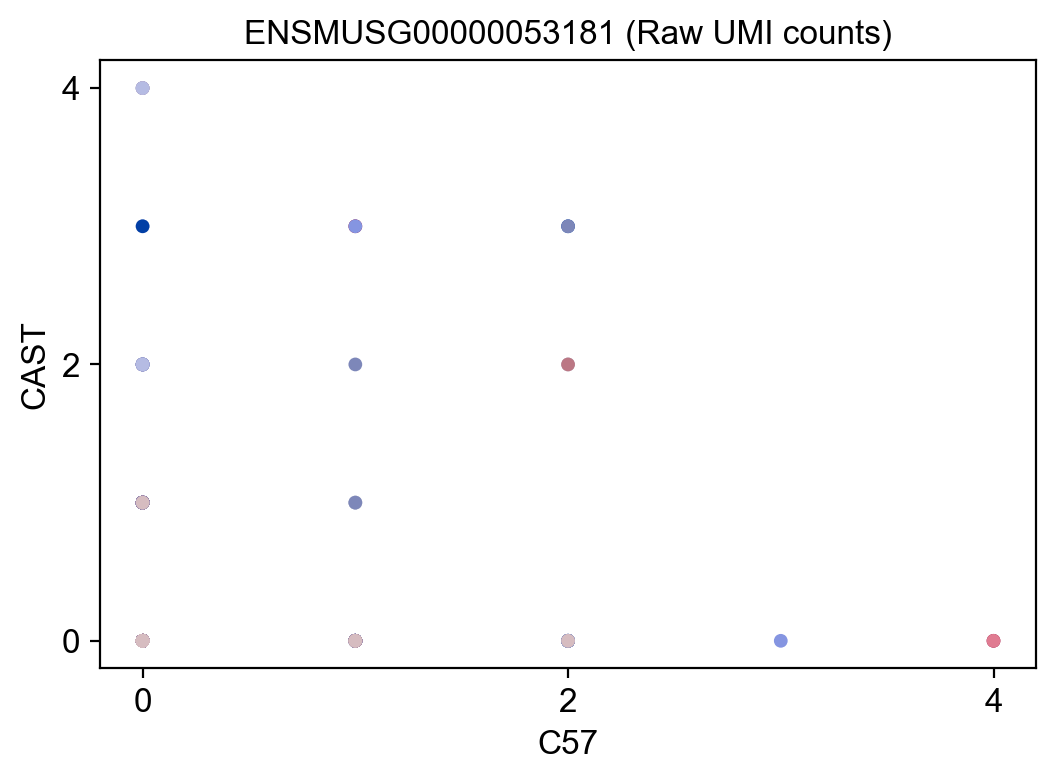

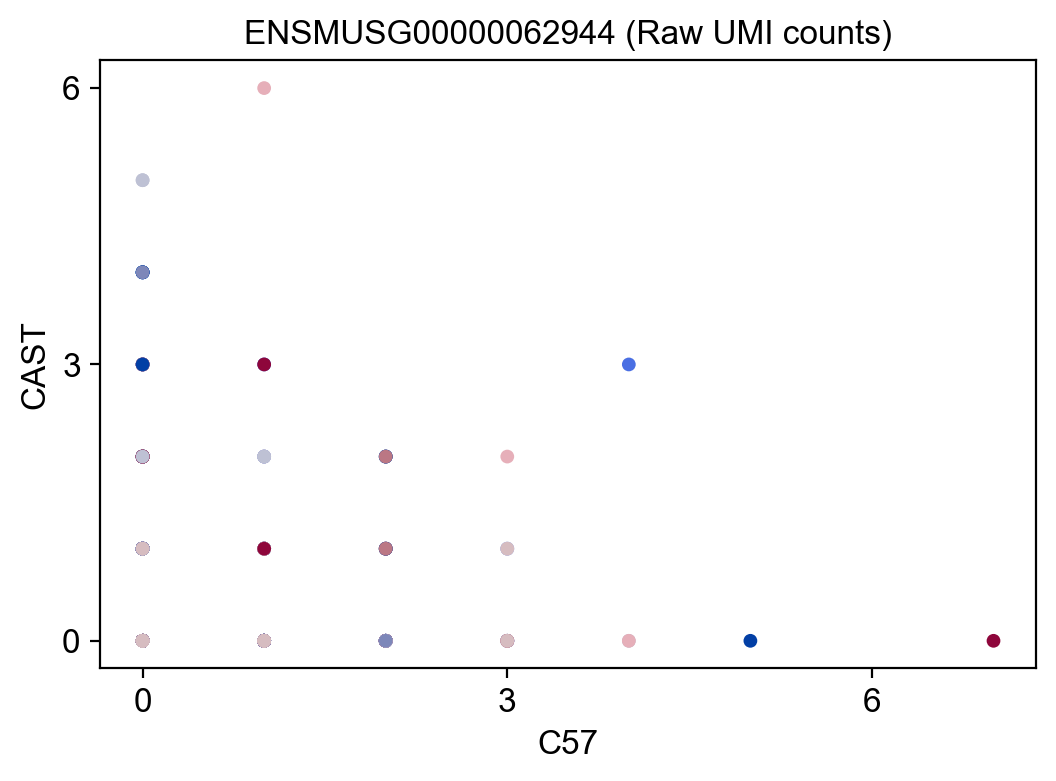

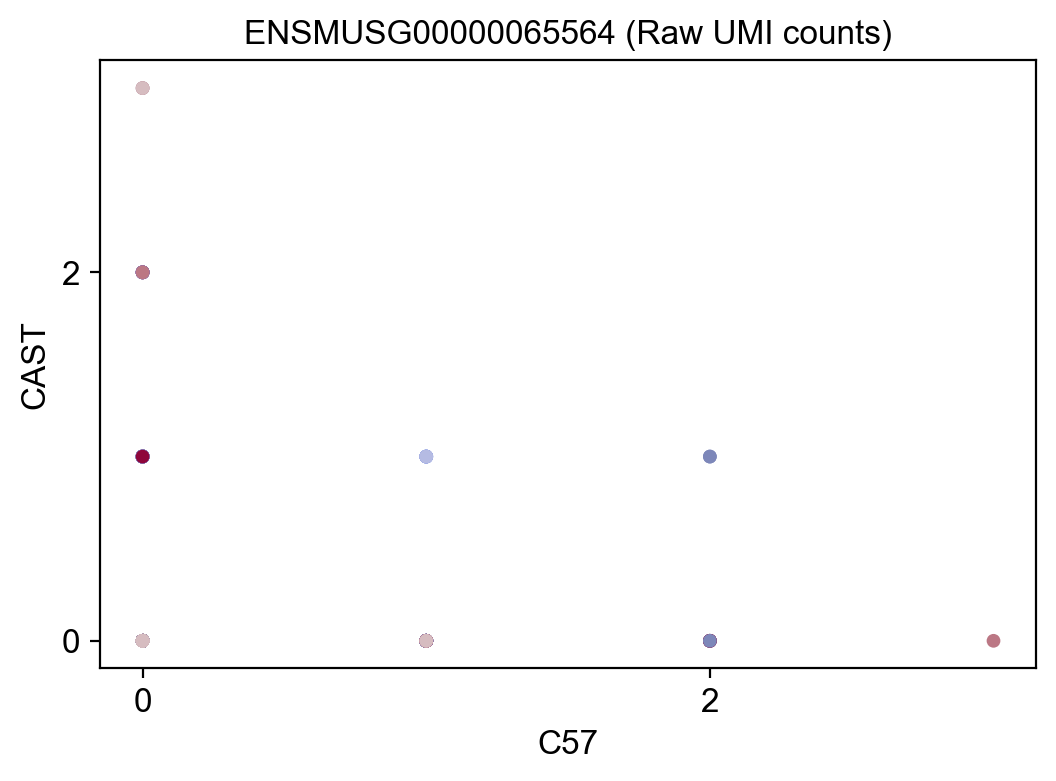

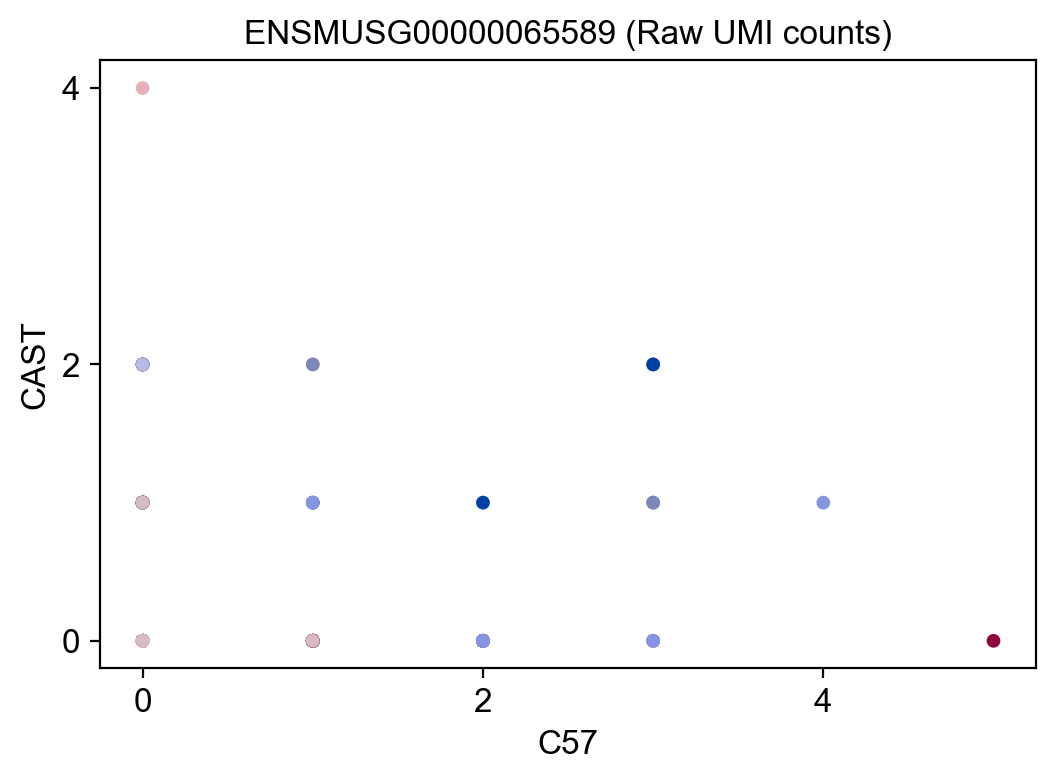

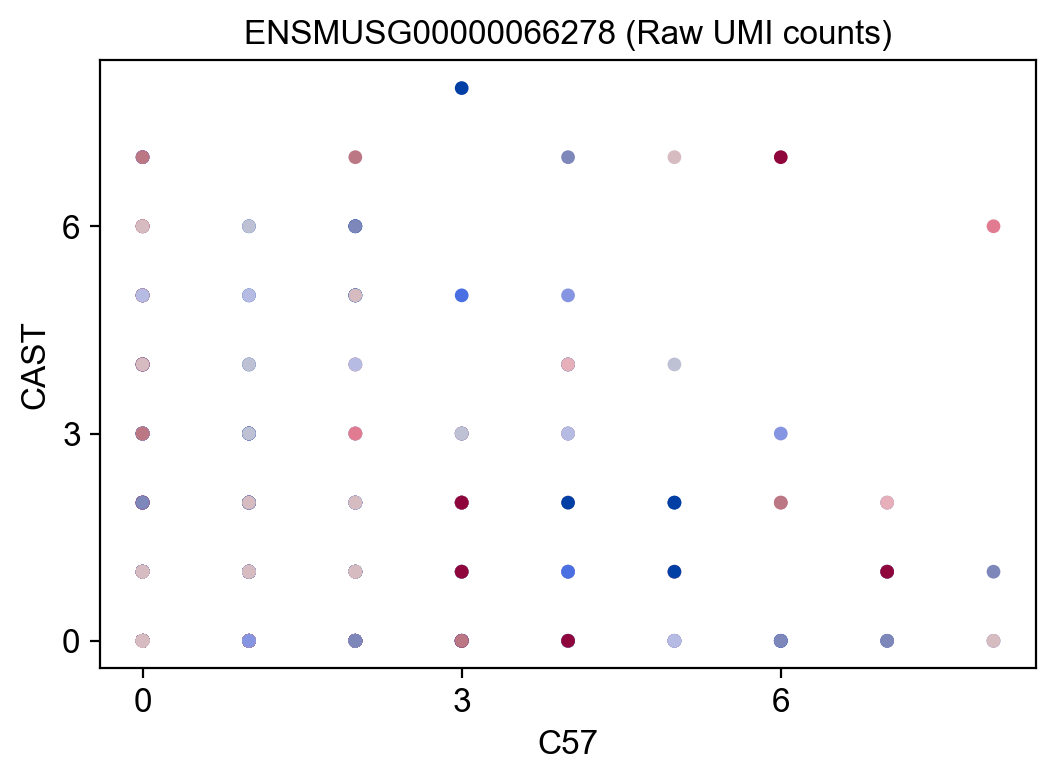

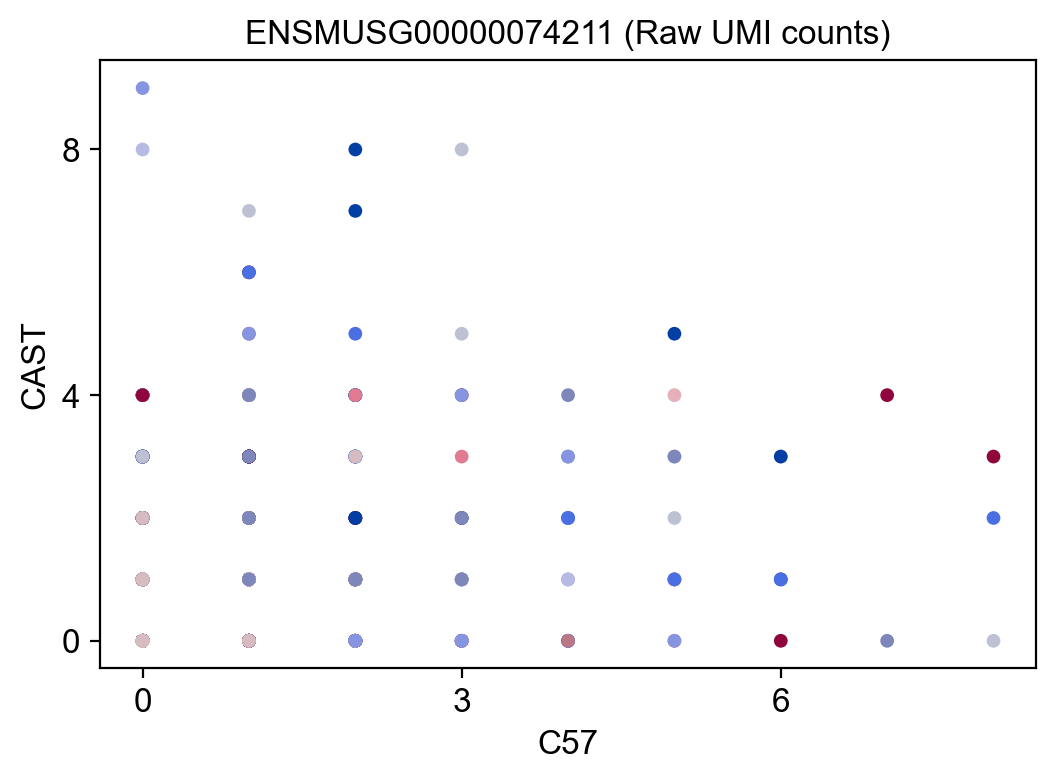

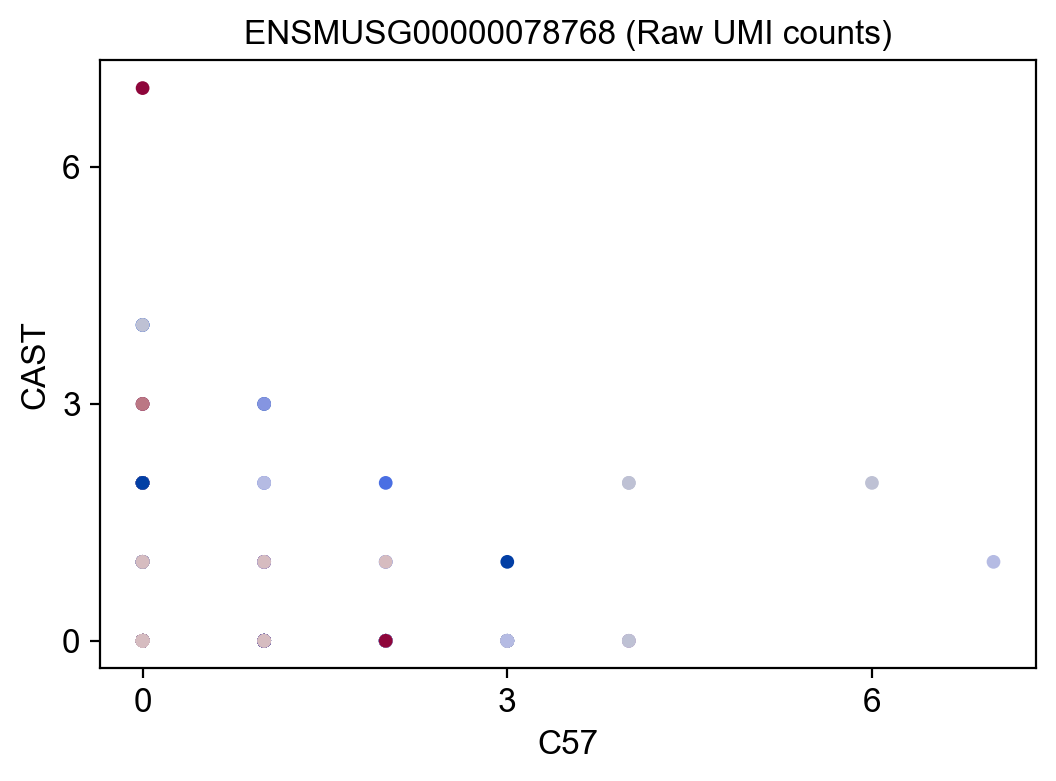

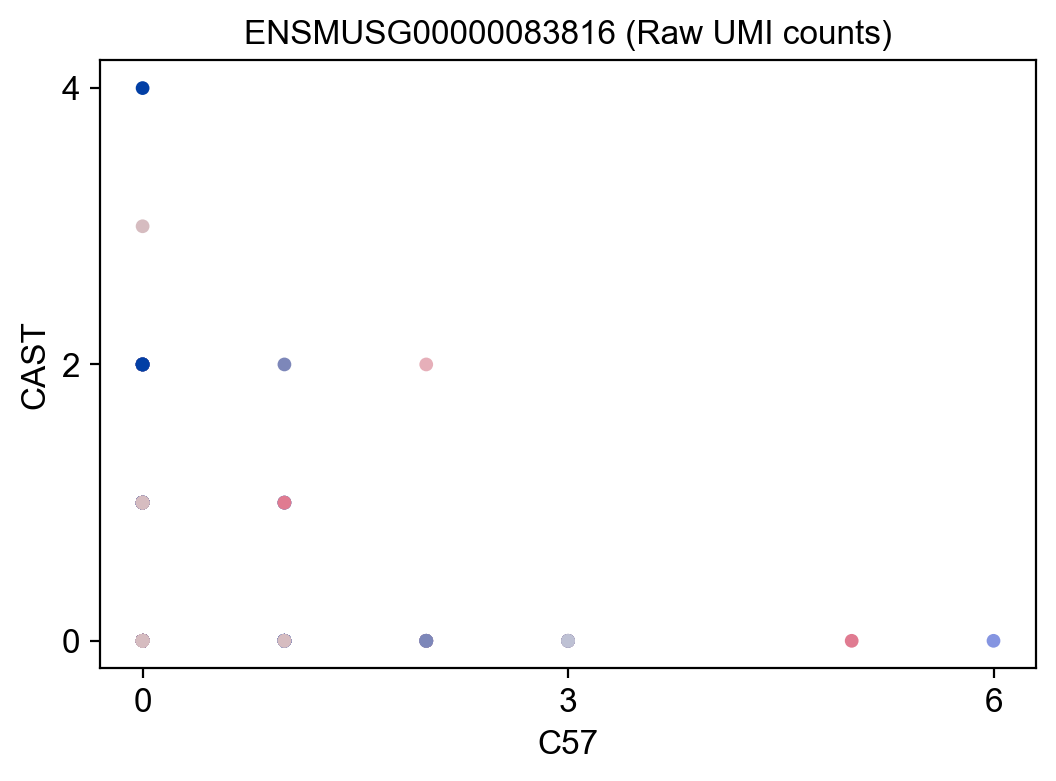

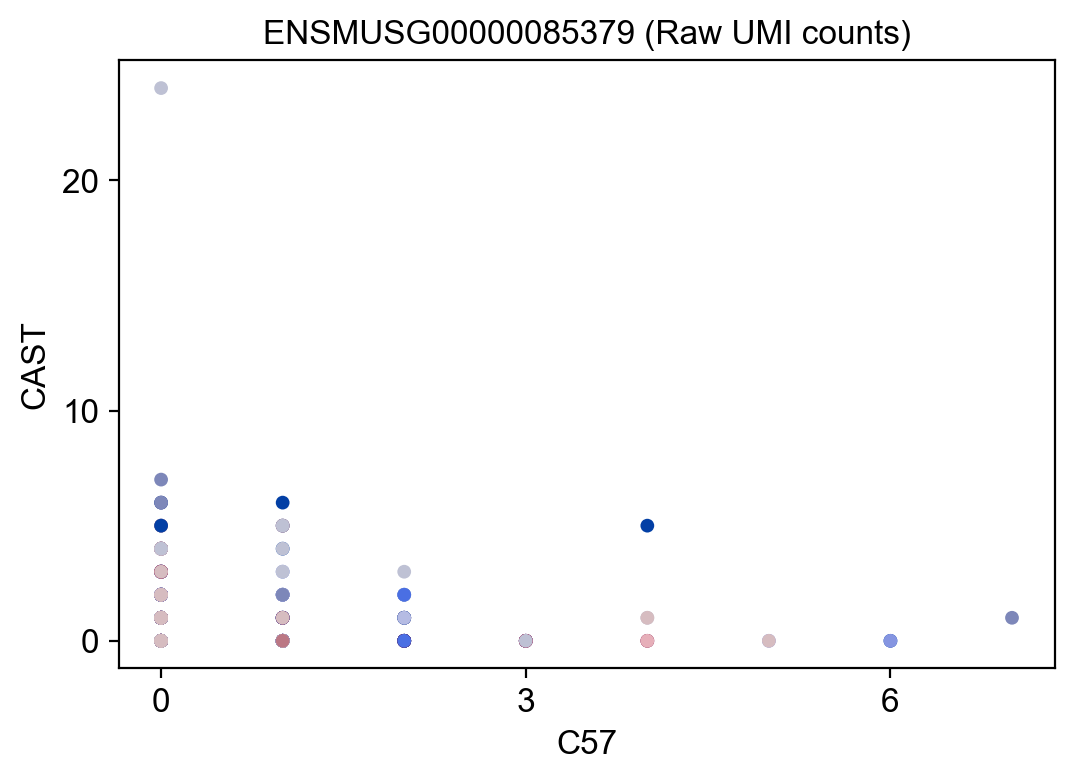

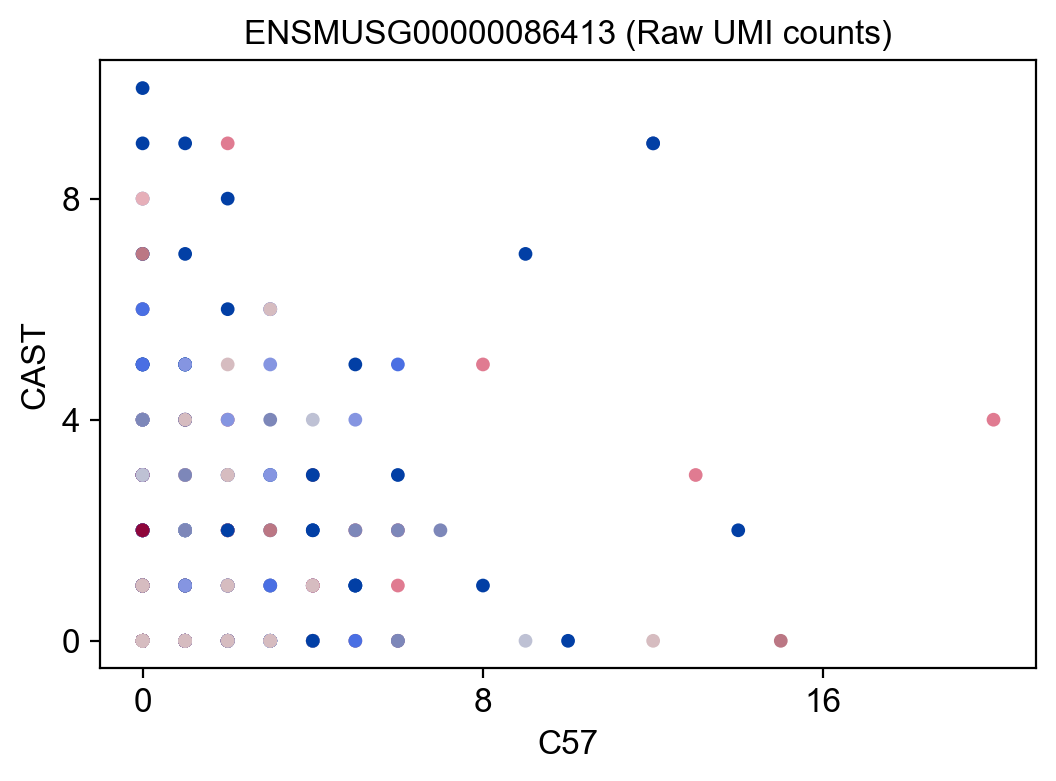

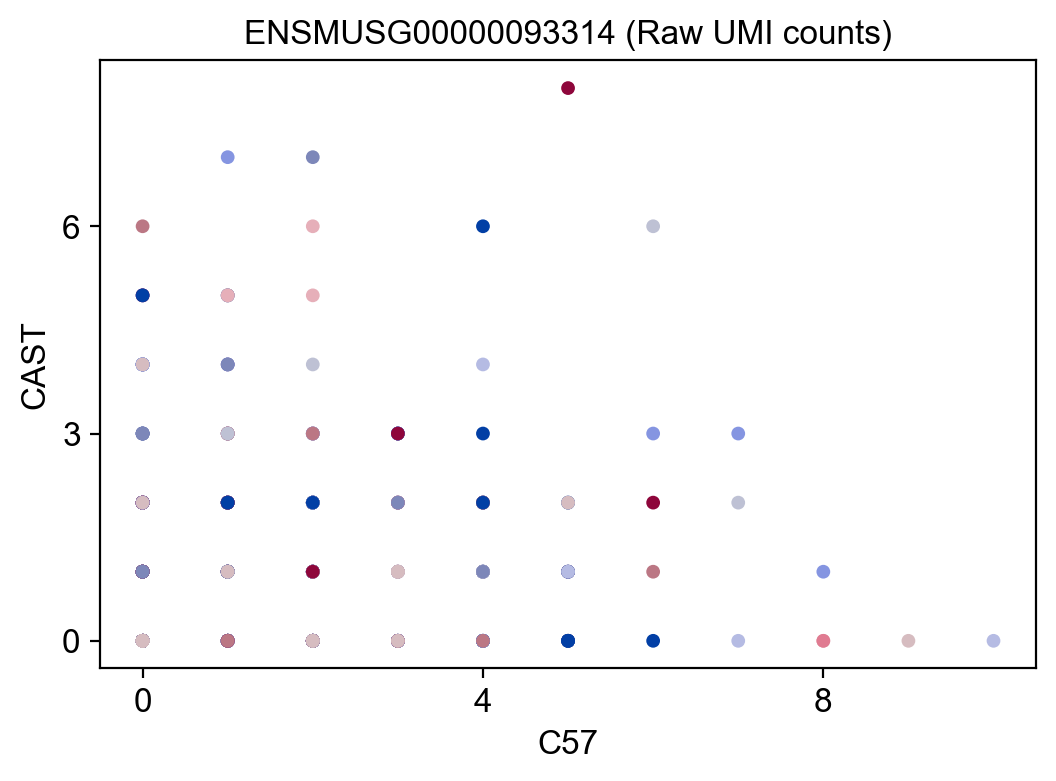

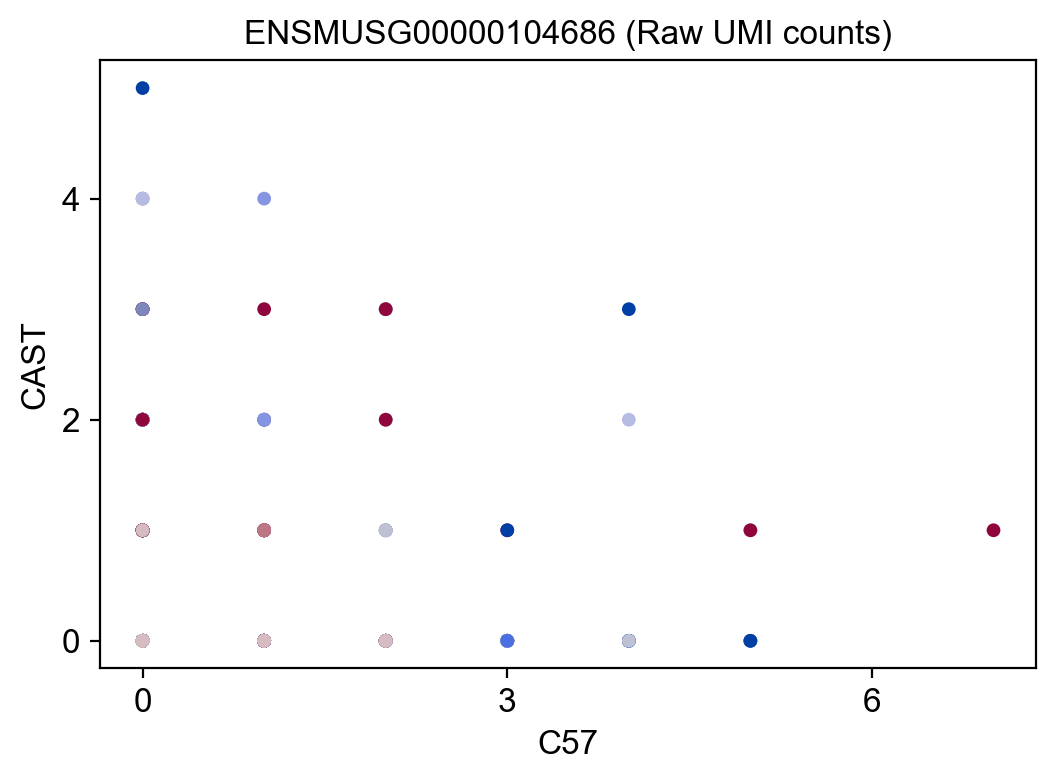

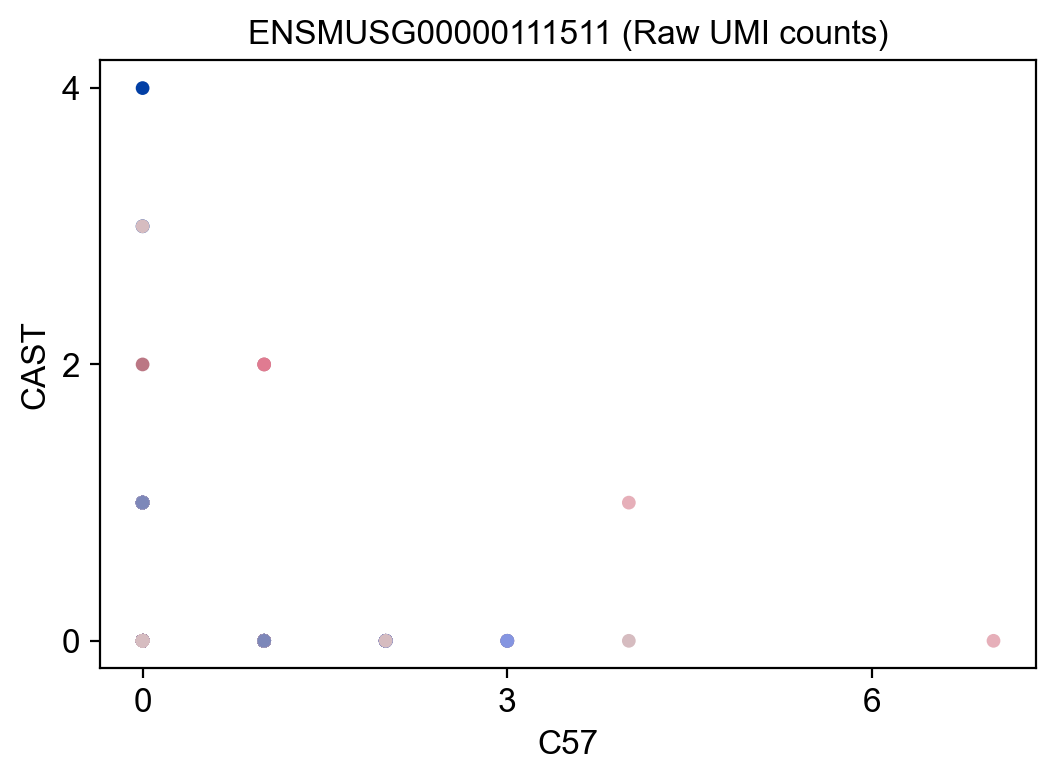

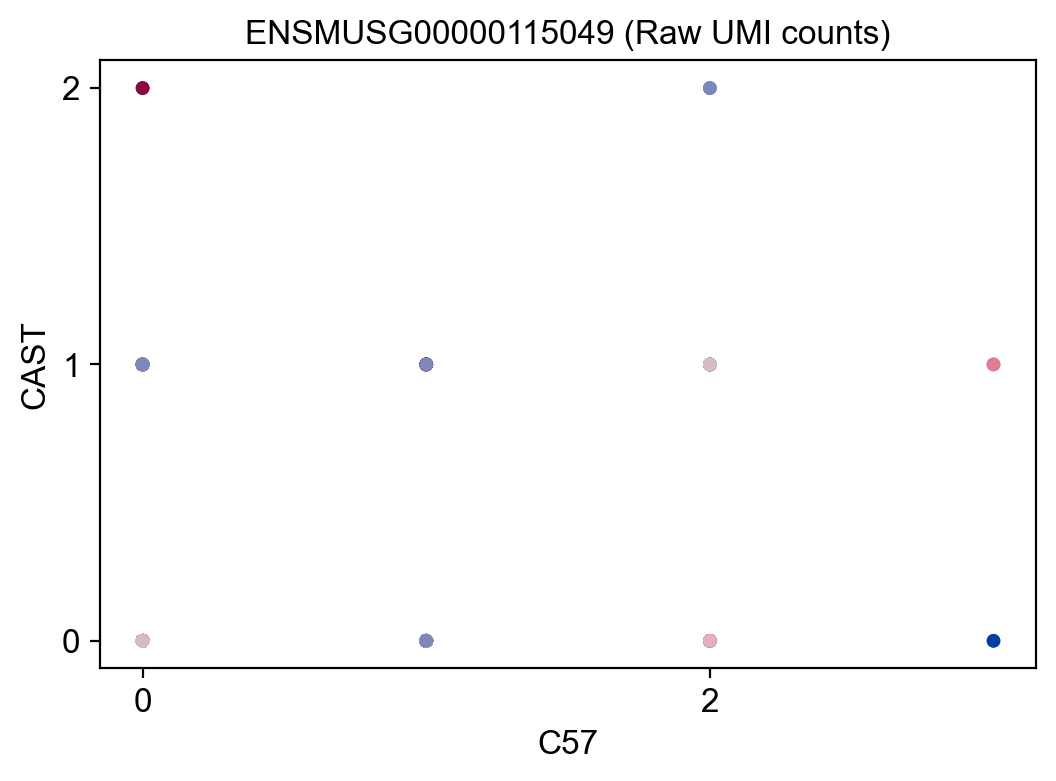

In [34]:
count = 1
for x in selected_genes3:
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'],
                       xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts)")
        count += 1

In [35]:
# scv.pl.scatter(adata, selected_genes3[2], color=['clusters'],
#                        xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts)")

In [36]:
# scv.pp.filter_and_normalize(adata, min_shared_counts=1, n_top_genes=20000)
# scv.pp.moments(adata, n_pcs=31, n_neighbors=8)
# adata

In [37]:
# scv.tl.recover_dynamics(adata, n_jobs = 8)

In [38]:
# scv.tl.velocity(adata, mode='dynamical')
# scv.tl.velocity_graph(adata)

In [39]:
# scv.pl.velocity_embedding_stream(adata, basis='umap')

In [40]:
# scv.tl.latent_time(adata)
# scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [41]:
# top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
# scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='leiden', n_convolve=100)

In [42]:
# kinetic rate params
# df2 = adata.var
# df2 = df2[(df2['fit_likelihood'] > .1) & df2['velocity_genes'] == True]

# kwargs = dict(xscale='log', fontsize=16)
# with scv.GridSpec(ncols=3) as pl:
#     pl.hist(df2['fit_alpha'], xlabel='transcription rate', **kwargs)
#     pl.hist(df2['fit_beta'] * df2['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
#     pl.hist(df2['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

# scv.get_df(adata, 'fit*', dropna=True).head()